In [1]:
from sys import path
if '..' not in path:
    path.insert(0, '..')

In [2]:
from os import path, makedirs, environ
import numpy as np
import random
import json

In [3]:
seed = 101
environ['PYTHONHASHSEED'] = str(seed)
environ["SM_FRAMEWORK"] = "tf.keras"
np.random.seed(seed) 
random.seed(seed)

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import _library.lstm_utils as lstm_utils

In [5]:
from _library.utils import SYSTEM_NAMES, SUBFOLDERS, load_datasets
from tensorflow.random import set_seed as tf_set_seed
from string import ascii_uppercase 
from collections import Counter
from re import match, findall
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import load_model 
from tensorflow.keras import metrics as metrics
from sklearn.ensemble import ExtraTreesClassifier

In [6]:
from tensorflow.python.client import device_lib
import tensorflow as tf
from tensorflow.keras import backend as K

In [7]:
display(tf.__version__)
#display(tf.config.list_physical_devices())
display(device_lib.list_local_devices())

'2.4.1'

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 975014519090297226, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 753664000
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 6598716998122979902
 physical_device_desc: "device: 0, name: NVIDIA TITAN Xp, pci bus id: 0000:05:00.0, compute capability: 6.1"]

In [8]:
tf_set_seed(seed)

In [9]:
%cd /mnt/data/vieri/projects/SAMPLE/

/mnt/data/vieri/projects/SAMPLE


# 1) The photovoltaic systems

In [10]:
print(SYSTEM_NAMES, "\nSUBFOLDERS: -->", SUBFOLDERS)
# --- 0 ---------- 1 ---------- 2 --------- 3 ---------- 4 -------

['Binetto 1', 'Binetto 2', 'Soleto 1', 'Soleto 2', 'Galatina'] 
SUBFOLDERS: --> ['Cleaned', '1-hour sampling', '1-hour averaged sampling', 'Residuals', 'Residuals_analytical', 'Failure events', None]


## 1.1) Selecting the PV system

In [11]:
system_name = SYSTEM_NAMES[4]

In [12]:
system_path = path.join('data', system_name.upper(), system_name.upper())
print(f"PV SYSTEM --> {system_name}")

PV SYSTEM --> Galatina


## 1.2) Load the failure logs

In [13]:
data_folder = 'Failure events'

In [14]:
file_name = 'HighMedium_failureEvent_logs.csv'

In [15]:
folder_path = path.join(system_path, 'Imported data' , data_folder)
fault_df, unique_events = lstm_utils.load_failure_logs(folder_path, file_name, system_name, verbose = True)

--------------------------------------------------------------------------------------------------------------
-------------------------------------------------- GALATINA --------------------------------------------------
--------------------------------------------------------------------------------------------------------------
Logs concerning failure events have been loaded.

---------------------------------------- DATA AVAILABLE ----------------------------------------
--> Inverter available (4):  1, 2, 3, 4
--> Unique events (5)
	--> 1) (HIGH) Allarme fusibile su polo negativo
	--> 2) (HIGH) Allarme fusibile su polo positivo
	--> 3) (HIGH) Isolamento
	--> 4) (HIGH) String-box con corrente a 0
	--> 5) (MEDIUM) Corrente di stringa fuori range

--> Unique string names available (12): s1, s2, s3, s4, s5, s6, s7, s8, s9, s10, s11, s12

--> General Plant box available (24):
	--> QC1.I1
	--> QC1.I2
	--> QC1.I3
	--> QC1.I4
	--> QC2.I1
	--> QC2.I2
	--> QC2.I3
	--> QC2.I4
	--> QC3.I1
	-->

# 2) Explore the data

## 2.1) The dataframe

In [16]:
print("-" * 110 + "\n" + "-" * 50, system_name.upper(), "-" * 50 + "\n" + "-" * 110)

print("\n", "-" * 40, 'FEATURES', "-" * 40)
fault_df.info()
print("\n" + "-" * 20, f'LOG EXAMPLES (COVERED PERIOD: FROM {fault_df["Inizio"].iloc[0].strftime("%Y-%m-%d")} '\
        f'TO {fault_df["Inizio"].iloc[-1].strftime("%Y-%m-%d")})', "-" * 20)

display(fault_df)

--------------------------------------------------------------------------------------------------------------
-------------------------------------------------- GALATINA --------------------------------------------------
--------------------------------------------------------------------------------------------------------------

 ---------------------------------------- FEATURES ----------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137365 entries, 0 to 137364
Data columns (total 9 columns):
 #   Column           Non-Null Count   Dtype          
---  ------           --------------   -----          
 0   Inverter         137365 non-null  Int64          
 1   Quadro Generale  137365 non-null  object         
 2   Stringa          135647 non-null  object         
 3   Tipo             137365 non-null  object         
 4   Causa Guasto     137365 non-null  object         
 5   Messaggio        137365 non-null  object         
 6   Durata           13

,Inverter,Quadro Generale,Stringa,Tipo,Causa Guasto,Messaggio,Durata,Inizio,Fine
0,1,QC6.I1,s1,Log_stringBox - Medium,Allarme string-box,Corrente di stringa fuori range,0 days 00:12:00,2016-05-07 15:16:00,2016-05-07 15:28:00
1,1,QC6.I1,s1,Log_stringBox - Medium,Allarme string-box,Corrente di stringa fuori range,0 days 15:04:00,2016-05-08 17:56:00,2016-05-09 09:00:00
2,1,QC6.I1,s1,Log_stringBox - Medium,Allarme string-box,Corrente di stringa fuori range,0 days 00:22:00,2016-05-09 10:18:00,2016-05-09 10:40:00
3,1,QC6.I1,s1,Log_stringBox - Medium,Allarme string-box,Corrente di stringa fuori range,0 days 01:16:00,2016-05-09 11:11:00,2016-05-09 12:27:00
4,1,QC6.I1,s1,Log_stringBox - Medium,Allarme string-box,Corrente di stringa fuori range,0 days 01:06:00,2016-05-09 13:19:00,2016-05-09 14:25:00
...,...,...,...,...,...,...,...,...,...
137360,1,QC6.I1,s7,Log_stringBox - Medium,Allarme string-box,Corrente di stringa fuori range,0 days 00:00:00,2021-09-14 16:00:00,2021-09-14 16:00:00
137361,1,QC6.I1,s12,Log_stringBox - Medium,Allarme string-box,Corrente di stringa fuori range,0 days 00:00:00,2021-09-14 16:00:00,2021-09-14 16:00:00
137362,1,QC6.I1,s10,Log_stringBox - Medium,Allarme string-box,Corrente di stringa fuori range,0 days 00:00:00,2021-09-14 16:00:00,2021-09-14 16:00:00
137363,4,QC5.I4,s9,Log_stringBox - Medium,Allarme string-box,Corrente di stringa fuori range,0 days 00:00:00,2021-09-14 16:00:00,2021-09-14 16:00:00


## 2.2) Visualize the grouped failure events

In [17]:
groups = [
    ['Inverter',  'Tipo', 'Messaggio'], 
    #['Inverter', 'Quadro Generale', 'Tipo', 'Messaggio'],
]

In [18]:
print("-" * 110 + "\n" + "-" * 50, system_name.upper(), "-" * 50 + "\n" + "-" * 110, "\n")
for idk, cols_to_group_by in enumerate(groups):
    print("-" * 52 + "\n" + "-" * 22, f"VIEW {idk + 1}", "-" * 22 + "\n" + "-" * 52)
    
    
    # Filtered by the first data available in the inverter
    if system_name == 'Soleto 1':
        inv_first_ts = pd.to_datetime('2018-08-08 11:00:00')
    elif system_name == 'Soleto 2':
        inv_first_ts = pd.to_datetime('2018-08-08 15:00:00')
    elif system_name == 'Galatina':
        inv_first_ts = pd.to_datetime('2019-08-12 18:00:00')
        
    fault_df = fault_df[fault_df['Inizio'] >= inv_first_ts]
    
    print(f"COLUMNS USED TO GROUP ({len(cols_to_group_by)}): ", ', '.join(cols_to_group_by))
    grouped_fault_df = fault_df.groupby(by = cols_to_group_by)['Durata'].agg(['count', 'mean', 'median', 'max', 'min', 'sum'])
    grouped_fault_df.rename(columns = {'sum': 'Summed period', 
                                       'count' : 'Total events',
                                       'mean' : 'Avgerage event duration',
                                       'median': 'Median event duration', 
                                       'max': 'Maxiumum event duration',
                                       'min': 'Minimum event duration'}, 
                            inplace = True)
    grouped_fault_df['Avgerage event duration'] = grouped_fault_df['Avgerage event duration'].apply(lambda ts: ts.round('s'))
    grouped_fault_df = grouped_fault_df.astype(str)
    
    display(fault_df)
    timestamps = sorted(fault_df['Inizio'].values)
    period_df = pd.DataFrame(
        data = [pd.to_datetime(timestamps[0]),pd.to_datetime(timestamps[-1]),
                pd.to_datetime(timestamps[-1]) - pd.to_datetime(timestamps[0])],
        index = ['First', 'Last', 'Total days'],
        columns = ['Period']
    )
    
    # Save the view
    file_name = system_name + " - StringBoxes_frequencies_.xlsx"
    save_folder_path = path.join("./data", system_name.upper(), system_name.upper(), "Fault analyses")
    
    if not path.exists(save_folder_path):
        makedirs(save_folder_path)
        print("A new saving folder has been created")
    
    #writer = pd.ExcelWriter(path.join(save_folder_path, file_name))
    
    #period_df.to_excel(writer,sheet_name = "Info", freeze_panes = (1, 0))
    #grouped_fault_df.to_excel(writer, sheet_name = "Grouped events", freeze_panes = (1, 3))
    
    #writer.save()
    print(f"Frequencies have been saved into {save_folder_path}")

    display(period_df)
    print('grouped_fault_df')
    display(grouped_fault_df)

--------------------------------------------------------------------------------------------------------------
-------------------------------------------------- GALATINA --------------------------------------------------
-------------------------------------------------------------------------------------------------------------- 

----------------------------------------------------
---------------------- VIEW 1 ----------------------
----------------------------------------------------
COLUMNS USED TO GROUP (3):  Inverter, Tipo, Messaggio


,Inverter,Quadro Generale,Stringa,Tipo,Causa Guasto,Messaggio,Durata,Inizio,Fine
8512,1,QC4.I1,NaN,Log_stringBox - High,String-box con corrente a 0,String-box con corrente a 0,90 days 23:49:00,2019-12-09 13:18:00,2020-03-09 13:07:00
8513,1,QC3.I1,NaN,Log_stringBox - High,String-box con corrente a 0,String-box con corrente a 0,90 days 23:49:00,2019-12-09 13:18:00,2020-03-09 13:07:00
8514,1,QC1.I1,NaN,Log_stringBox - High,String-box con corrente a 0,String-box con corrente a 0,94 days 01:46:00,2019-12-09 13:18:00,2020-03-12 15:04:00
8515,1,QC2.I1,NaN,Log_stringBox - High,String-box con corrente a 0,String-box con corrente a 0,94 days 01:46:00,2019-12-09 13:18:00,2020-03-12 15:04:00
8516,1,QC5.I1,NaN,Log_stringBox - High,String-box con corrente a 0,String-box con corrente a 0,90 days 23:49:00,2019-12-09 13:18:00,2020-03-09 13:07:00
...,...,...,...,...,...,...,...,...,...
137360,1,QC6.I1,s7,Log_stringBox - Medium,Allarme string-box,Corrente di stringa fuori range,0 days 00:00:00,2021-09-14 16:00:00,2021-09-14 16:00:00
137361,1,QC6.I1,s12,Log_stringBox - Medium,Allarme string-box,Corrente di stringa fuori range,0 days 00:00:00,2021-09-14 16:00:00,2021-09-14 16:00:00
137362,1,QC6.I1,s10,Log_stringBox - Medium,Allarme string-box,Corrente di stringa fuori range,0 days 00:00:00,2021-09-14 16:00:00,2021-09-14 16:00:00
137363,4,QC5.I4,s9,Log_stringBox - Medium,Allarme string-box,Corrente di stringa fuori range,0 days 00:00:00,2021-09-14 16:00:00,2021-09-14 16:00:00


Frequencies have been saved into ./data/GALATINA/GALATINA/Fault analyses


,Period
First,2019-12-09 13:18:00
Last,2021-09-14 16:00:00
Total days,645 days 02:42:00


grouped_fault_df


Total events  \
Inverter Tipo                   Messaggio                                      
1        Log_stringBox - High   Isolamento                                 1   
                                String-box con corrente a 0              255   
         Log_stringBox - Medium Corrente di stringa fuori range        54696   
2        Log_stringBox - High   Isolamento                                 1   
                                String-box con corrente a 0               67   
         Log_stringBox - Medium Corrente di stringa fuori range        22881   
3        Log_stringBox - High   Isolamento                               254   
                                String-box con corrente a 0               42   
         Log_stringBox - Medium Corrente di stringa fuori range        20786   
4        Log_stringBox - High   String-box con corrente a 0              246   
         Log_stringBox - Medium Corrente di stringa fuori range        29624   

                                                                Avgerage event duration  \
Inverter Tipo                   Messaggio                                                 
1        Log_stringBox - High   Isolamento                              0 days 00:31:00   
                                String-box con corrente a 0             3 days 13:10:02   
         Log_stringBox - Medium Corrente di stringa fuori range         0 days 00:37:15   
2        Log_stringBox - High   Isolamento                              0 days 00:17:00   
                                String-box con corrente a 0             2 days 23:12:27   
         Log_stringBox - Medium Corrente di stringa fuori range         0 days 00:45:15   
3        Log_stringBox - High   Isolamento                              0 days 00:22:24   
                                String-box con corrente a 0            10 days 20:31:19   
         Log_stringBox - Medium Corrente di stringa fuori range         0 days 01:06:07   
4        Log_stringBox - High   String-box con corrente a 0             2 days 04:25:59   
         Log_stringBox - Medium Corrente di stringa fuori range         0 days 00:34:05   

                                                                Median event duration  \
Inverter Tipo                   Messaggio                                               
1        Log_stringBox - High   Isolamento                            0 days 00:31:00   
                                String-box con corrente a 0           0 days 01:31:00   
         Log_stringBox - Medium Corrente di stringa fuori range       0 days 00:13:00   
2        Log_stringBox - High   Isolamento                            0 days 00:17:00   
                                String-box con corrente a 0           0 days 00:42:00   
         Log_stringBox - Medium Corrente di stringa fuori range       0 days 00:13:00   
3        Log_stringBox - High   Isolamento                            0 days 00:14:00   
                                String-box con corrente a 0           0 days 01:28:00   
         Log_stringBox - Medium Corrente di stringa fuori range       0 days 00:18:00   
4        Log_stringBox - High   String-box con corrente a 0           0 days 01:31:30   
         Log_stringBox - Medium Corrente di stringa fuori range       0 days 00:12:00   

                                                                Maxiumum event duration  \
Inverter Tipo                   Messaggio                                                 
1        Log_stringBox - High   Isolamento                              0 days 00:31:00   
                                String-box con corrente a 0           197 days 20:18:00   
         Log_stringBox - Medium Corrente di stringa fuori range         0 days 09:29:00   
2        Log_stringBox - High   Isolamento                              0 days 00:17:00   
                                String-box con corrente a 0           143 days 23:29:00   
         Log_stringBox - Medium Corrente di 

# 3) Data preparation

## 3.1) Create the dataframe using the new concept

In [19]:
prefix_gb = "QC"

In [20]:
# Indexes 
starting_ts = fault_df['Inizio'].iloc[0].strftime('%Y-%m-%d %H')
ending_ts = pd.to_datetime(fault_df['Fine'].iloc[-1].strftime('%Y-%m-%d %H')) + pd.Timedelta(1, unit = 'hour')
timestamps = pd.date_range(starting_ts, ending_ts, freq = "1H")

# Columns
num_generalBoxes = 6
num_stringBoxes_per_gb = 12
names = [f'{prefix_gb}{gb}_s{sb}' if sb != 0 else f'{prefix_gb}{gb}' for gb in range(1, num_generalBoxes + 1) 
         for sb in range(0, num_stringBoxes_per_gb + 1)]

# Remove the 'extra' string boxes
#to_remove = [f'{prefix_gb}1_s10', f'{prefix_gb}1_s11', f'{prefix_gb}1_s12']
#for name in to_remove:
#    names.remove(name)
    
# Add a column for the labels (i.e., array that contains the alarm high)
output_col_name = 'Labels'
names.insert(0, output_col_name)

# Create input/output columns
input_classes = [event for event, priority in unique_events.items() if priority == 'medium']
output_classes = [event for event, priority in unique_events.items() if priority == 'high']

### Generate the inverter names

In [21]:
prefix_inv_name = 'INV'

In [22]:
num_inverters = 4 if (system_name != 'Soleto 2') else 2
inv_names = [prefix_inv_name + str(inv_num) for inv_num in range(1, num_inverters + 1)]

## 3.2) Fill the new dataframe

### 3.2.1) Fill the space for each inverter

In [23]:
inv_stringBoxes_data = dict()

for inv_name in inv_names.copy():
    print("\n" + "-" * 40, inv_name, "-" * 40)

    # 1) Retrieve the failure events concerning the inverter 
    inv_num = int(inv_name[-1])
    inv_alarms = fault_df[fault_df['Inverter'] == inv_num]
    #display(inv_alarms)
    
    # 1.2) Chech whethere there are alarms with high priority
    has_high_alarms = True if len([type_name for type_name in inv_alarms['Tipo'].unique() 
                                   if 'HIGH' in type_name.upper()]) > 0 else False
    if not has_high_alarms:
        print(f"\t[{inv_name}] it does not have any log concerning high-priority alarms.")
        inv_names.remove(inv_name)
        continue
    
    # 2) Create the empty dataframe
    empty_matrix_df = pd.DataFrame(data = np.zeros(shape = (len(timestamps), len(names))), index = timestamps, columns = names)
    empty_matrix_df = empty_matrix_df.applymap(lambda cell: np.zeros(len(input_classes), dtype = int))
    empty_matrix_df.loc[:, output_col_name] = empty_matrix_df[output_col_name].apply(
        lambda cell: np.zeros(len(output_classes), dtype = int))
    
    # 3.1) Use the empty matrix as starting point
    stringBoxes_df = empty_matrix_df
    
    # 3.2) Fill the new dataframe by iterating each alarm log
    rowWise_func = lambda alarm: lstm_utils.fill_stringBoxes_data(alarm, stringBoxes_df, input_classes, output_classes, 
                                                                  output_col_name, prefix_gb, system_name, verbose = False)
    inv_alarms.apply(func = rowWise_func, axis = 1)
    
     # 3.3) Assign the new filled space 
    inv_stringBoxes_data[inv_name] = stringBoxes_df
    
    # 4) Check the missing string Boxes
    summed_min = stringBoxes_df.iloc[:, 1:].sum(axis = 0).apply(np.sum)
    missing_stringBoxes = summed_min[summed_min == 0].index.tolist()
    summed_labels = stringBoxes_df[output_col_name].apply(np.sum)
    summed_labels = summed_labels[summed_labels > 0].index.tolist()
    print(f"Positive values within {len(summed_labels)} labels "\
          f"({round((len(summed_labels)/len(stringBoxes_df)) * 100, 2)} %) out of {len(stringBoxes_df)}")
    print(f"Data available for {len(stringBoxes_df.columns) - len(missing_stringBoxes)} string boxes "\
          f"({round(((len(stringBoxes_df.columns[1:]) - len(missing_stringBoxes))/len(stringBoxes_df.columns[1:])) * 100, 2)} %)"\
          f" out of {len(stringBoxes_df.columns[1:])} ")
    print(f"Missing ones ({len(missing_stringBoxes)})\n\t-->", '\n\t--> '.join(missing_stringBoxes))


---------------------------------------- INV1 ----------------------------------------
Positive values within 9050 labels (58.44 %) out of 15485
Data available for 58 string boxes (73.08 %) out of 78 
Missing ones (21)
	--> QC1
	--> QC1_s10
	--> QC1_s11
	--> QC1_s12
	--> QC2
	--> QC2_s1
	--> QC2_s2
	--> QC2_s3
	--> QC2_s4
	--> QC2_s5
	--> QC2_s6
	--> QC2_s7
	--> QC2_s8
	--> QC2_s9
	--> QC2_s10
	--> QC2_s11
	--> QC2_s12
	--> QC3
	--> QC4
	--> QC5
	--> QC6

---------------------------------------- INV2 ----------------------------------------
Positive values within 3494 labels (22.56 %) out of 15485
Data available for 36 string boxes (44.87 %) out of 78 
Missing ones (43)
	--> QC1
	--> QC1_s2
	--> QC1_s3
	--> QC1_s8
	--> QC1_s9
	--> QC2
	--> QC2_s1
	--> QC2_s7
	--> QC3
	--> QC3_s1
	--> QC3_s2
	--> QC3_s6
	--> QC3_s7
	--> QC3_s8
	--> QC3_s9
	--> QC3_s10
	--> QC3_s11
	--> QC3_s12
	--> QC4
	--> QC4_s1
	--> QC4_s4
	--> QC4_s5
	--> QC4_s7
	--> QC5
	--> QC5_s1
	--> QC5_s2
	--> QC5_s3
	--> QC5

## 3.3) Create the probabilities for the labels (i.e., high alarms)

### 3.3.1) Turn the total minutes of the labels into probabilities (0, 1)

In [24]:
prob_as_labels = True

In [25]:
if prob_as_labels:
    for inv_name in inv_names:
        print("\n" + "-" * 110 + "\n" + "-" * 50, inv_name, "-" * 50 + "\n" + "-" * 110, "\n")

        # Retrieve the main dataset
        df = inv_stringBoxes_data[inv_name]
       
        # Turn the total minutes of the lables into probabilities
        ex_pre = df.iloc[0].copy()
        df.loc[:, output_col_name] = df[output_col_name].apply(lambda cell_array: np.where(cell_array > 0, 1, cell_array))
        
        print(f"{inv_name}: EXAMPLE ({ex_pre.name}): LABELS: {ex_pre[output_col_name]} --> {df[output_col_name].iloc[0]}")

else:
    print("The total minutes will be used as labels.")


--------------------------------------------------------------------------------------------------------------
-------------------------------------------------- INV1 --------------------------------------------------
-------------------------------------------------------------------------------------------------------------- 

INV1: EXAMPLE (2019-12-09 13:00:00): LABELS: [  0   0   0 252] --> [0 0 0 1]

--------------------------------------------------------------------------------------------------------------
-------------------------------------------------- INV2 --------------------------------------------------
-------------------------------------------------------------------------------------------------------------- 

INV2: EXAMPLE (2019-12-09 13:00:00): LABELS: [0 0 0 0] --> [0 0 0 0]

--------------------------------------------------------------------------------------------------------------
-------------------------------------------------- INV3 ----------------------

## 3.4) Integrate the inverter data

### 3.4.1) Load the inverter data

In [26]:
dataset_name = '1-hour averaged sampling'

In [27]:
system_path, inv_data, *_ = load_datasets(system_name, subfolder = dataset_name)

-------------------------------------------------------------------------------- 
				PV SYSTEM --> GALATINA 
--------------------------------------------------------------------------------

Loading inverter data...
GALATINA: OK, component data loaded (4) --> INV1, INV2, INV3, INV4
-------------------------------------------------------------------------------- 
FINISHED!: All datasets have been loaded. (SYS: 4 - IRR FILE: 0)
--------------------------------------------------------------------------------
-------------------------------------------------------------------------------- 
EXAMPLE --> Galatina: INV1 (FROM '2019-11-27' TO '2021-06-30': 581 days).
--------------------------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8818 entries, 0 to 8817
Data columns (total 20 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   Date/Time  

### 3.4.2) Merge the data

In [28]:
selected_inv_columns = ['Cc 1 (A)', 'Vcc 1 (V)', 'Irradiance (W/mq)', 'Amb. Temp (°C)', 
                        'Humidity (%)', 'Atmospheric Pressure (hPa)', 'Rainfall (mm)'] 

In [29]:
fill_nan_values = True


--------------------------------------------------------------------------------------------------------------
-------------------------------------------------- INV1 --------------------------------------------------
-------------------------------------------------------------------------------------------------------------- 

ALARMS DF: 15485
INVERTER DF: 8818
--> Columns (7): Cc 1 (A), Vcc 1 (V), Irradiance (W/mq), Amb. Temp (°C), Humidity (%), Atmospheric Pressure (hPa), Rainfall (mm)
--> Missing inverter data: 6845 (44.2 %)


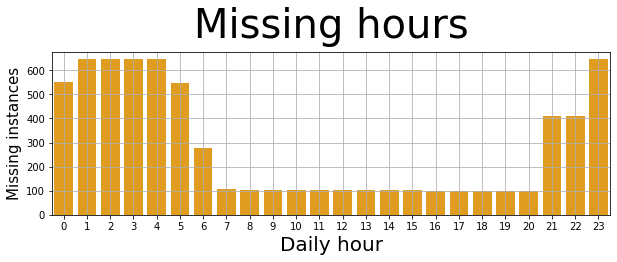

--> Filled the (inverter) missing values.
--> Observations with missing values (20515) have been dropped.


,Cc 1 (A),Vcc 1 (V),Irradiance (W/mq),Amb. Temp (°C),Humidity (%),Atmospheric Pressure (hPa),Rainfall (mm),Labels,QC1,QC1_s1,...,QC6_s3,QC6_s4,QC6_s5,QC6_s6,QC6_s7,QC6_s8,QC6_s9,QC6_s10,QC6_s11,QC6_s12
2019-12-09 13:00:00,47.0,424.0,197.0,15.83,79.75,1008.34,0.0,"[0, 0, 0, 1]",[0],[0],...,[0],[0],[0],[0],[0],[0],[0],[0],[0],[0]
2019-12-09 14:00:00,131.0,413.0,352.0,16.08,74.87,1007.69,0.0,"[0, 0, 0, 1]",[0],[0],...,[0],[0],[0],[0],[0],[0],[0],[0],[0],[0]
2019-12-09 15:00:00,128.0,402.0,380.0,17.10,65.24,1007.00,0.2,"[0, 0, 0, 1]",[0],[0],...,[0],[0],[0],[0],[0],[0],[0],[0],[0],[0]
2019-12-09 16:00:00,46.0,393.0,142.0,15.95,71.37,1006.69,0.0,"[0, 0, 0, 1]",[0],[0],...,[0],[0],[0],[0],[0],[0],[0],[0],[0],[0]
2019-12-09 17:00:00,0.0,171.0,19.0,14.84,78.50,1006.50,0.0,"[0, 0, 0, 1]",[0],[0],...,[0],[0],[0],[0],[0],[0],[0],[0],[0],[0]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-06-30 18:00:00,102.0,399.0,220.0,35.00,32.63,1006.39,0.0,"[0, 0, 0, 0]",[0],[0],...,[0],[0],[0],[0],[0],[0],[0],[0],[0],[0]
2021-06-30 19:00:00,56.0,406.0,136.0,32.88,44.55,1006.78,0.0,"[0, 0, 0, 0]",[0],[0],...,[0],[0],[0],[0],[0],[0],[0],[0],[0],[0]
2021-06-30 20:00:00,8.0,408.0,51.0,29.10,73.56,1006.86,0.0,"[0, 0, 0, 0]",[0],[0],...,[0],[0],[0],[0],[0],[0],[0],[0],[0],[0]
2021-06-30 21:00:00,0.0,232.0,15.0,27.67,78.14,1006.79,0.0,"[0, 0, 0, 0]",[0],[0],...,[0],[0],[0],[0],[0],[0],[0],[0],[0],[0]



--------------------------------------------------------------------------------------------------------------
-------------------------------------------------- INV2 --------------------------------------------------
-------------------------------------------------------------------------------------------------------------- 

ALARMS DF: 15485
INVERTER DF: 13912
--> Columns (7): Cc 1 (A), Vcc 1 (V), Irradiance (W/mq), Amb. Temp (°C), Humidity (%), Atmospheric Pressure (hPa), Rainfall (mm)
--> Missing inverter data: 6833 (44.13 %)


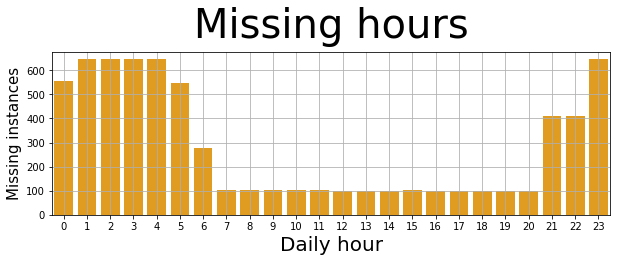

--> Filled the (inverter) missing values.
--> Observations with missing values (20479) have been dropped.


,Cc 1 (A),Vcc 1 (V),Irradiance (W/mq),Amb. Temp (°C),Humidity (%),Atmospheric Pressure (hPa),Rainfall (mm),Labels,QC1,QC1_s1,...,QC6_s3,QC6_s4,QC6_s5,QC6_s6,QC6_s7,QC6_s8,QC6_s9,QC6_s10,QC6_s11,QC6_s12
2019-12-09 13:00:00,51.0,405.0,197.0,15.83,79.75,1008.34,0.0,"[0, 0, 0, 0]",[0],[0],...,[0],[0],[0],[0],[0],[0],[0],[0],[0],[0]
2019-12-09 14:00:00,128.0,404.0,366.0,16.08,74.87,1007.69,0.0,"[0, 0, 0, 0]",[0],[0],...,[0],[0],[0],[0],[0],[0],[0],[0],[0],[0]
2019-12-09 15:00:00,132.0,389.0,380.0,17.10,65.24,1007.00,0.2,"[0, 0, 0, 0]",[0],[0],...,[0],[0],[0],[0],[0],[0],[0],[0],[0],[0]
2019-12-09 16:00:00,44.0,400.0,142.0,15.95,71.37,1006.69,0.0,"[0, 0, 0, 0]",[0],[0],...,[0],[0],[0],[0],[0],[0],[0],[0],[0],[0]
2019-12-09 17:00:00,0.0,199.0,20.0,14.84,78.50,1006.50,0.0,"[0, 0, 0, 0]",[0],[0],...,[0],[0],[0],[0],[0],[0],[0],[0],[0],[0]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-06-30 18:00:00,106.0,392.0,220.0,35.00,32.63,1006.39,0.0,"[0, 0, 0, 0]",[0],[0],...,[0],[0],[0],[0],[0],[0],[0],[0],[0],[0]
2021-06-30 19:00:00,59.0,397.0,140.0,32.88,44.55,1006.78,0.0,"[0, 0, 0, 0]",[0],[0],...,[0],[0],[0],[0],[0],[0],[0],[0],[0],[0]
2021-06-30 20:00:00,8.0,413.0,51.0,29.10,73.56,1006.86,0.0,"[0, 0, 0, 0]",[0],[0],...,[0],[0],[0],[0],[0],[0],[0],[0],[0],[0]
2021-06-30 21:00:00,0.0,238.0,15.0,27.67,78.14,1006.79,0.0,"[0, 0, 0, 0]",[0],[0],...,[0],[0],[0],[0],[0],[0],[0],[0],[0],[0]



--------------------------------------------------------------------------------------------------------------
-------------------------------------------------- INV3 --------------------------------------------------
-------------------------------------------------------------------------------------------------------------- 

ALARMS DF: 15485
INVERTER DF: 14753
--> Columns (7): Cc 1 (A), Vcc 1 (V), Irradiance (W/mq), Amb. Temp (°C), Humidity (%), Atmospheric Pressure (hPa), Rainfall (mm)
--> Missing inverter data: 6604 (42.65 %)


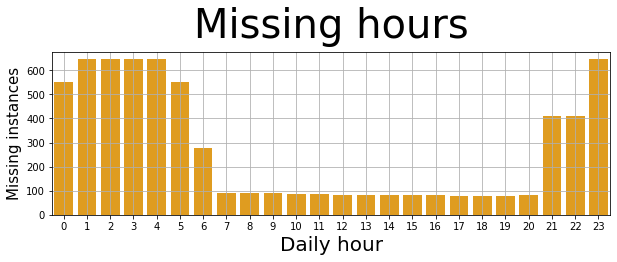

--> Filled the (inverter) missing values.
--> Observations with missing values (19786) have been dropped.


,Cc 1 (A),Vcc 1 (V),Irradiance (W/mq),Amb. Temp (°C),Humidity (%),Atmospheric Pressure (hPa),Rainfall (mm),Labels,QC1,QC1_s1,...,QC6_s3,QC6_s4,QC6_s5,QC6_s6,QC6_s7,QC6_s8,QC6_s9,QC6_s10,QC6_s11,QC6_s12
2019-12-09 13:00:00,52.0,371.0,197.0,15.83,79.75,1008.34,0.0,"[0, 0, 0, 0]",[0],[0],...,[0],[0],[0],[0],[0],[0],[0],[0],[0],[0]
2019-12-09 14:00:00,141.0,375.0,366.0,16.08,74.87,1007.69,0.0,"[0, 0, 0, 0]",[0],[0],...,[0],[0],[0],[0],[0],[0],[0],[0],[0],[0]
2019-12-09 15:00:00,138.0,366.0,380.0,17.10,65.24,1007.00,0.2,"[0, 0, 0, 0]",[0],[0],...,[0],[0],[0],[0],[0],[0],[0],[0],[0],[0]
2019-12-09 16:00:00,42.0,372.0,142.0,15.95,71.37,1006.69,0.0,"[0, 0, 0, 0]",[0],[0],...,[0],[0],[0],[0],[0],[0],[0],[0],[0],[0]
2019-12-09 17:00:00,0.0,187.0,20.0,14.84,78.50,1006.50,0.0,"[0, 0, 0, 0]",[0],[0],...,[0],[0],[0],[0],[0],[0],[0],[0],[0],[0]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-06-30 18:00:00,103.0,392.0,220.0,35.00,32.63,1006.39,0.0,"[0, 0, 0, 1]",[0],[0],...,[0],[38],[38],[0],[0],[0],[38],[6],[0],[38]
2021-06-30 19:00:00,54.0,395.0,140.0,32.88,44.55,1006.78,0.0,"[0, 0, 0, 1]",[0],[0],...,[0],[60],[60],[0],[0],[0],[60],[60],[0],[60]
2021-06-30 20:00:00,8.0,404.0,51.0,29.10,73.56,1006.86,0.0,"[0, 0, 0, 1]",[0],[0],...,[0],[60],[60],[0],[0],[0],[60],[60],[0],[60]
2021-06-30 21:00:00,0.0,243.0,15.0,27.67,78.14,1006.79,0.0,"[0, 0, 0, 1]",[0],[0],...,[0],[60],[60],[0],[0],[0],[60],[60],[0],[60]



--------------------------------------------------------------------------------------------------------------
-------------------------------------------------- INV4 --------------------------------------------------
-------------------------------------------------------------------------------------------------------------- 

ALARMS DF: 15485
INVERTER DF: 9337
--> Columns (7): Cc 1 (A), Vcc 1 (V), Irradiance (W/mq), Amb. Temp (°C), Humidity (%), Atmospheric Pressure (hPa), Rainfall (mm)
--> Missing inverter data: 6918 (44.68 %)


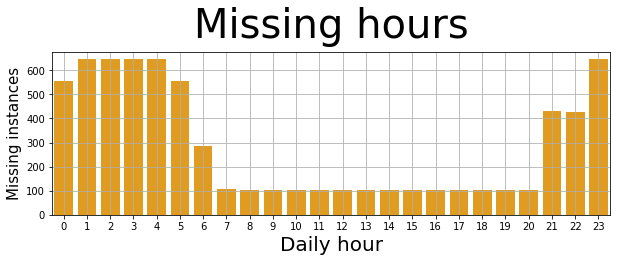

--> Filled the (inverter) missing values.
--> Observations with missing values (20728) have been dropped.


,Cc 1 (A),Vcc 1 (V),Irradiance (W/mq),Amb. Temp (°C),Humidity (%),Atmospheric Pressure (hPa),Rainfall (mm),Labels,QC1,QC1_s1,...,QC6_s3,QC6_s4,QC6_s5,QC6_s6,QC6_s7,QC6_s8,QC6_s9,QC6_s10,QC6_s11,QC6_s12
2019-12-09 13:00:00,49.0,379.0,197.0,15.83,79.75,1008.34,0.0,"[0, 0, 0, 0]",[0],[0],...,[0],[0],[0],[0],[0],[0],[0],[0],[0],[0]
2019-12-09 14:00:00,136.0,379.0,366.0,16.08,74.87,1007.69,0.0,"[0, 0, 0, 0]",[0],[0],...,[0],[0],[0],[0],[0],[0],[0],[0],[0],[0]
2019-12-09 15:00:00,136.0,373.0,380.0,17.10,65.24,1007.00,0.2,"[0, 0, 0, 0]",[0],[0],...,[0],[0],[0],[0],[0],[0],[0],[0],[0],[0]
2019-12-09 16:00:00,46.0,363.0,142.0,15.95,71.37,1006.69,0.0,"[0, 0, 0, 0]",[0],[0],...,[0],[0],[0],[0],[0],[0],[0],[0],[0],[0]
2019-12-09 17:00:00,0.0,185.0,20.0,14.84,78.50,1006.50,0.0,"[0, 0, 0, 0]",[0],[0],...,[0],[0],[0],[0],[0],[0],[0],[0],[0],[0]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-06-19 05:00:00,0.0,220.0,13.0,20.34,65.44,1009.93,0.0,"[0, 0, 0, 0]",[0],[0],...,[0],[0],[0],[0],[0],[0],[0],[0],[0],[0]
2021-06-19 06:00:00,0.0,324.0,16.0,19.44,71.78,1010.01,0.0,"[0, 0, 0, 0]",[0],[0],...,[0],[0],[0],[0],[0],[0],[0],[0],[0],[0]
2021-06-20 06:00:00,0.0,325.0,16.0,21.78,62.39,1007.95,0.0,"[0, 0, 0, 0]",[0],[0],...,[0],[0],[0],[0],[0],[0],[0],[0],[0],[0]
2021-06-20 17:00:00,226.0,394.0,481.0,33.16,38.19,1006.59,0.0,"[0, 0, 0, 0]",[0],[0],...,[0],[0],[13],[0],[0],[0],[0],[0],[0],[0]


In [30]:
for inv_name in inv_names:
    print("\n" + "-" * 110 + "\n" + "-" * 50, inv_name, "-" * 50 + "\n" + "-" * 110, "\n")
    
    # Retrieve the main dataset
    df = inv_stringBoxes_data[inv_name]
    print("ALARMS DF:", len(df))
    
    # Retrieve the inverter data
    inv_df = inv_data[inv_name]
    inv_df.index = inv_df['Date/Time']
    
    # Select only the relevant columns concerning the inverter
    inv_df = inv_df[selected_inv_columns]
    print("INVERTER DF:", len(inv_df))
    print(f"--> Columns ({len(selected_inv_columns)}):", ', '.join(selected_inv_columns))
    
    # Merge the data
    merged_df = inv_df.merge(df, how = 'right', left_index = True, right_index = True)
 
    # Chech the NaN values
    empty_ts = set(merged_df[merged_df.isnull().values].index)
    empty_hours = np.array(sorted(Counter(item.strftime('%H') for item in empty_ts).most_common(), key = lambda item: item[0]))
    print(f"--> Missing inverter data: {len(empty_ts)} ({(round((len(empty_ts)/len(merged_df))* 100, 2))} %)")

    plt.figure(figsize = (10, 3))
    sns.barplot(x = [int(hour) for hour in empty_hours[:, 0]], y =  [int(counter) for counter in empty_hours[:, 1]], 
                color = 'orange')
    plt.title("Missing hours", fontsize = 40, y = 1.05)
    plt.xlabel('Daily hour', fontsize = 20)
    plt.ylabel('Missing instances', fontsize = 15)
    plt.grid()
    plt.show()
    
    # CASE 1: Fille nan values
    if fill_nan_values:
        merged_df.loc[:, 'Cc 1 (A)'].fillna(method = 'ffill', inplace = True) 
        merged_df.loc[:, 'Vcc 1 (V)'].fillna(method = 'ffill',  inplace = True)
        merged_df.loc[:, 'Irradiance (W/mq)'].fillna(method = 'ffill', inplace = True)
        merged_df.loc[:, 'Amb. Temp (°C)'].fillna(method = 'ffill', inplace = True)
        print("--> Filled the (inverter) missing values.")
    
    # Drop observations that was not filled 
    print(f"--> Observations with missing values ({len(merged_df[merged_df.isnull().values])}) have been dropped.")
    merged_df.dropna(inplace = True)

    # Assign the merged_df to its inverter
    inv_stringBoxes_data[inv_name] = merged_df
    
    display(merged_df)

## 3.5) Create features for each pair of class and stringbox

In [31]:
class_prefix = 'CLASS'

In [32]:
for inv_name in inv_names:
    print("-" * 110 + "\n" + "-" * 50, inv_name, "-" * 50 + "\n" + "-" * 110, "\n")
    
    # Retrieve the dataset
    df = inv_stringBoxes_data[inv_name]
    
    # The different cases
    class_col = 'Labels'
    stringBox_cols = [col for col in df.columns if (col not in selected_inv_columns) and (col != class_col)]
    
    # Split the data
    partial_dfs = []
    
    # A) Split the labels (i.e., outputs)
    partial_dfs.append(pd.DataFrame(
            data = df[class_col].tolist(), 
            columns = [f'{class_prefix} {ascii_uppercase[idk]}: {class_name}' 
                       for idk, class_name in enumerate(output_classes)], 
            index = df.index
        ))
    
    # Inverter features
    partial_dfs.append(df[selected_inv_columns])
    
    # B) Split the string box data
    for col in stringBox_cols:
        partial_dfs.append(pd.DataFrame(
            data = df[col].tolist(), 
            columns = [f'{col}: {class_name}' for class_name in input_classes], 
            index = df.index
        ))
        
    # C) Build the merged dataframe
    merged_splitted_df = pd.concat(partial_dfs, axis = 1)
    
    # Save the splitted df
    inv_stringBoxes_data[inv_name] = merged_splitted_df
    print("\t\t\t\t\t\t OK\n")

#print("COLUMNS:\n--> " + '\n--> '.join(inv_stringBoxes_data[inv_name].columns))

--------------------------------------------------------------------------------------------------------------
-------------------------------------------------- INV1 --------------------------------------------------
-------------------------------------------------------------------------------------------------------------- 

						 OK

--------------------------------------------------------------------------------------------------------------
-------------------------------------------------- INV2 --------------------------------------------------
-------------------------------------------------------------------------------------------------------------- 

						 OK

--------------------------------------------------------------------------------------------------------------
-------------------------------------------------- INV3 --------------------------------------------------
--------------------------------------------------------------------------------------------------

## 3.6) Remove reduntant features (i.e., unnecessary pairs)

In [33]:
remove_redundant_features = True

In [34]:
redundant_pairs = {
    'Corrente di stringa fuori range': r"^QC\d$", # QCX
    'String-box con produzione anomala': r"QC\d_s\d{1,2}$" # QCX_sY
}

In [35]:
if remove_redundant_features:
    for inv_name in inv_names:
        print("-" * 110 + "\n" + "-" * 50, inv_name, "-" * 50 + "\n" + "-" * 110, "\n")

        # Retrieve the dataset
        df = inv_stringBoxes_data[inv_name]
        cols_to_remove = df.columns.tolist()
        print("TOTAL COLUMNS:", len(cols_to_remove))
        
        # Retrive columns having all zeros (no failure events)
        #summed_df = df.sum(axis = 0)
        #zeros_cols = summed_df[summed_df == 0].index.tolist()

        # Remove the output columns from the columns having all zero values
        [cols_to_remove.remove(col_name) for col_name in cols_to_remove.copy() if class_prefix in col_name]
        
        # Remove the inverter data
        [cols_to_remove.remove(col_name) for col_name in cols_to_remove.copy() if col_name in selected_inv_columns]
        
        # Select only the unnecessary features (i.e., pairs_to_remove)
        for full_col_name in cols_to_remove.copy():
            component_prefix, alarm = [item.strip() for item in full_col_name.split(':')]

            if alarm in redundant_pairs.keys():
                regex_prefix_to_check = redundant_pairs[alarm]
  
                # Select only features matching the prefix to discard 
                if not match(regex_prefix_to_check, component_prefix):
                    cols_to_remove.remove(full_col_name)
            else:
                # Select only features that is considered as pairs (i.e., pairs_to_remove)
                cols_to_remove.remove(full_col_name)

        # Remove the columns 
        if len(cols_to_remove) > 0:
            print(f"--> Removed {len(cols_to_remove)} columns that were unnecessary!\n"\
                  f"CURRENT FEATURES: from {len(df.columns)} to {len(df.columns) - len(cols_to_remove)}\n")
            df.drop(columns = cols_to_remove, inplace = True)
        else:
            print("There are no unnecessary columns!\n")

--------------------------------------------------------------------------------------------------------------
-------------------------------------------------- INV1 --------------------------------------------------
-------------------------------------------------------------------------------------------------------------- 

TOTAL COLUMNS: 89
--> Removed 6 columns that were unnecessary!
CURRENT FEATURES: from 89 to 83

--------------------------------------------------------------------------------------------------------------
-------------------------------------------------- INV2 --------------------------------------------------
-------------------------------------------------------------------------------------------------------------- 

TOTAL COLUMNS: 89
--> Removed 6 columns that were unnecessary!
CURRENT FEATURES: from 89 to 83

--------------------------------------------------------------------------------------------------------------
-----------------------------------

## 3.7) Generate the train/test split

In [36]:
train_data = dict()
test_data = dict()

In [37]:
test_size = 0.3

In [46]:
for inv_name in inv_names:
    print("\n" + "-" * 110 + "\n" + "-" * 50, inv_name, "-" * 50 + "\n" + "-" * 110, "\n")
    df = inv_stringBoxes_data[inv_name]
    display(df.iloc[0, [0, 1, 2, 3, 11, 12, 14, 14]].to_frame().transpose())
    output_cols = [col for col in df.columns if class_prefix in col]
    nonZeros = df[output_cols].sum() 
    cols_with_only_one_value = nonZeros[nonZeros == 1].index.tolist()
    for col in cols_with_only_one_value:
        output_cols.remove(col)

    #y = df[output_cols].values #.agg(lambda x: '-'.join(x.astype(str).values), axis=1).T
    #display(y)
    #y = [class_list.tolist() for class_list in df[output_cols].values]
    #print(type(y[0]))
    #display(y)
    #classes, y_indices = np.unique(y, return_inverse=True)
    #n_classes = classes.shape[0]
    #print(f"CLASSES {classes.shape} -->", classes)
        
    # Train/test split
    try: 
        train_df, test_df = train_test_split(df, test_size = test_size, stratify = df[output_cols].values, random_state = 101)
    except ValueError:
         train_df, test_df = train_test_split(df, test_size = test_size, random_state = 101)

    train_data[inv_name] = train_df.sort_index()
    test_data[inv_name] = test_df.sort_index()

    print(f"TRAIN SET ({int((1- test_size)*100)} %): {len(train_df)} obs. \n" + "-" * 50)
    display(train_df[output_cols].sum())
        
    print(f"TEST SET ({int(test_size * 100)} %):  {len(test_df)} obs. \n" + "-" * 50)
    display(test_df[output_cols].sum())


--------------------------------------------------------------------------------------------------------------
-------------------------------------------------- INV1 --------------------------------------------------
-------------------------------------------------------------------------------------------------------------- 



,CLASS A: Allarme fusibile su polo negativo,CLASS B: Allarme fusibile su polo positivo,CLASS C: Isolamento,CLASS D: String-box con corrente a 0,QC1_s1: Corrente di stringa fuori range,QC1_s2: Corrente di stringa fuori range,QC1_s4: Corrente di stringa fuori range,QC1_s4: Corrente di stringa fuori range
2019-12-09 13:00:00,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


NameError: name 'test_size' is not defined

## 3.8) Standard scaler

In [39]:
standardize_input_data = True

In [40]:
data_std_scalers = dict()
if standardize_input_data:
    for inv_name in inv_names:
        print("\n" + "-" * 110 + "\n" + "-" * 50, inv_name, "-" * 50 + "\n" + "-" * 110)
        
        # Retrieve the data
        train_df = train_data[inv_name]
        test_df = test_data[inv_name]

        input_cols = [col_name for col_name in train_df.columns if class_prefix not in col_name]
                
        # Select only the columns concerning the input features
        cols_to_strandardized = input_cols
        train_df = train_df[cols_to_strandardized]
        test_df = test_df[cols_to_strandardized]
        
        skipped_cols = sorted(set(train_data[inv_name].columns.tolist()) - set(cols_to_strandardized))
        print(f"Skipped the following ({len(skipped_cols)}) columns:\n--> " + '\n--> '.join(skipped_cols))
        
        # StandardScaler
        scaler = StandardScaler().fit(train_df)
        data_std_scalers[inv_name] = scaler
        
        # Transform the TRAIN data
        scaled_partial_train_df = pd.DataFrame(data = scaler.transform(train_df), index = train_df.index, 
                                               columns = train_df.columns)
        train_data[inv_name].loc[:, cols_to_strandardized] = scaled_partial_train_df
        print("\n--> a) TRAIN: it has been standardized.")

        # Transform the TEST data
        scaled_partial_test_df = pd.DataFrame(data = scaler.transform(test_df), index = test_df.index, 
                                              columns = test_df.columns)
        test_data[inv_name].loc[:, cols_to_strandardized] = scaled_partial_test_df
        print("--> b) TEST: it has been standardized (using a fitted StandardScaler).\n")
else:
    print("This pre-processing step (Data standardization) has not been selected.")


--------------------------------------------------------------------------------------------------------------
-------------------------------------------------- INV1 --------------------------------------------------
--------------------------------------------------------------------------------------------------------------
Skipped the following (4) columns:
--> CLASS A: Allarme fusibile su polo negativo
--> CLASS B: Allarme fusibile su polo positivo
--> CLASS C: Isolamento
--> CLASS D: String-box con corrente a 0

--> a) TRAIN: it has been standardized.
--> b) TEST: it has been standardized (using a fitted StandardScaler).


--------------------------------------------------------------------------------------------------------------
-------------------------------------------------- INV2 --------------------------------------------------
--------------------------------------------------------------------------------------------------------------
Skipped the following (4) columns

In [1]:
for inv_name in inv_names:
    print("\n" + "-" * 110 + "\n" + "-" * 50, inv_name, "-" * 50 + "\n" + "-" * 110)
        
    scaler = data_std_scalers[inv_name]
    
    file_path = path.join(main_folder_path, 'Params', f'{inv_name}_stdScaler.txt')
    
    with open(file_path, 'w') as txt_file:
        txt_file.write(f"\n[Standard Scaler] [{inv_name}]\n")
        txt_file.write("FEATURES:\n" + ','.join(scaler.feature_names_in_)+ "\n")
        txt_file.write("MEAN:\n" + ','.join([str(value) for value in scaler.mean_]) + "\n")
        txt_file.write("VARIANCE:\n" + ','.join([str(value) for value in scaler.var_]) + "\n")
        
        print(f"[{inv_name}] The paramaters (i.e., mean and variance) of the standard scaler have been saved. ")  

NameError: name 'inv_names' is not defined

## Data exploration
### Feature selection

In [41]:
visualize_exploration = False

In [42]:
if visualize_exploration:
    for inv_name in inv_names:        
        # Retrieve the data
        df = train_data[inv_name]

        output_cols = [col for col in df.columns if class_prefix in col]
        inputs_cols = np.array([col for col in df.columns if col not in output_cols])
        #print("INV columns\n" + '\n'.join(selected_inv_columns))

        # Input data
        inputs = df[inputs_cols]
        outputs = df[output_cols]

        # Tree
        clf = ExtraTreesClassifier(n_estimators = 500, random_state = 101)
        clf.fit(inputs, outputs)

        # Get the coef.
        importance = list(zip(inputs_cols, clf.feature_importances_))
        importance = sorted(importance, key = lambda item: item[1], reverse = True)

        # Visulize
        fig, axes = plt.subplots(figsize = (10, 20),  facecolor = "white")
        fig.suptitle(f"{system_name.upper()}: Inverter n°{inv_name[-1]}", fontsize = 60, color = 'firebrick')
        sns.barplot(x = [item[1] for item in importance], 
                    y = [item[0] for item in importance], 
                    palette = ['red' if feature_name in selected_inv_columns else 'orange' for feature_name, _ in importance],
                    ax = axes)
        axes.set_title("Feature importances via coefficients", pad = 20, size = 30)
        axes.tick_params(axis = 'x', top = True, labeltop = True)
        plt.show()

## 3.9) [END] Data preparation

In [43]:
idk = 0
print("-" * 110 + "\n" + "-" * 50, "TRAIN:", inv_names[idk], "-" * 50 + "\n" + "-" * 110, "\n")
train_data[inv_names[idk]].info()
#display(train_data[inv_names[idk]])

--------------------------------------------------------------------------------------------------------------
-------------------------------------------------- TRAIN: INV1 --------------------------------------------------
-------------------------------------------------------------------------------------------------------------- 

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6048 entries, 2019-12-09 13:00:00 to 2021-06-30 20:00:00
Data columns (total 83 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   CLASS A: Allarme fusibile su polo negativo  6048 non-null   int64  
 1   CLASS B: Allarme fusibile su polo positivo  6048 non-null   int64  
 2   CLASS C: Isolamento                         6048 non-null   int64  
 3   CLASS D: String-box con corrente a 0        6048 non-null   int64  
 4   Cc 1 (A)                                    6048 non-null   float64
 5   Vcc

# Logistic LSTM 

In [74]:
grid_search = False

In [75]:
pre_trained = False

In [76]:
avg_config = True

## Fixed parameters

In [77]:
num_epochs = 100
batch_size = 16

In [78]:
enconding_one_obs = True

## Create the saving folders

In [79]:
trained_inv_model = dict()

In [80]:
main_saving_folder = 'UC2 - LSTM'
saving_path = path.join(system_path, "..", "..", main_saving_folder)

if not path.exists(main_saving_folder):
    makedirs(main_saving_folder)
    print(f"The folder '{saving_folder}' has been created!")

In [81]:
subfolders = ['Grid search', 'Trained models', 'Test metrics']
for subfolder in subfolders:
    sub_saving_path = path.join(saving_path, subfolder)
    
    if not path.exists(sub_saving_path):
        makedirs(sub_saving_path)
        print(f"The sub-folder '{main_saving_folder}/{subfolder}' has been created!")

## Grid search

### The parameters

In [82]:
neurons_values = [16, 32, 64, 92, 128, 192]
window_dims = [2, 4, 6, 8, 12, 18, 24, 36, 48, 72, 96, 120]

### The function

In [83]:
verbose = True

In [84]:
grid_search_best_params = dict()
if grid_search and not pre_trained: 
    inv_best_scores = dict()
    for inv_name in inv_names[2:3]:
        print("-" * 110 + "\n" + "-" * 50, inv_name, "-" * 50 + "\n" + "-" * 110, "\n")

        # Retrieve the dataset
        df = train_data[inv_name]

        # Build the train/validation splits
        output_cols = [col for col in df.columns if class_prefix in col]

        best_scores = None

        # Test the combiantion of the two hyper-parameters
        print("-" * 110 + "\n" + "-" * 50, "GRID SEARCH", "-" * 50 + "\n" + "-" * 110)
        for i, starting_num_neurons in enumerate(neurons_values):
            for j, dim_window in enumerate(window_dims):
                print("\n" + "-" * 40)
                print(f"({i + 1}/{len(neurons_values)}) Starting neurons:", starting_num_neurons)
                print(f"({j + 1}/{len(window_dims)}) Temporal window:", dim_window, "hours")
                print("-" * 40, "\n")

                # Prepare the data
                feature_names, x_train, y_train, x_valid, y_valid = lstm_utils.prepare_splitted_training_data(df, output_cols,
                                                                                                              dim_window,
                                                                                                              enconding_one_obs)
                # Initialize the LSTM network
                num_input_features = x_train.shape[2]
                num_output_classes = y_train.shape[1]
                lstm_model = lstm_utils.initialize_lstm(starting_num_neurons, dim_window, num_input_features, num_output_classes, 
                                                        enconding_one_obs)

                # Train the LSTM 
                history, best_config_perfomances = lstm_utils.train_model(lstm_model, (x_train, y_train), (x_valid, y_valid), 
                                                                          num_epochs, batch_size, shuffle_flag = True, 
                                                                          visualize_graph = True)
                best_config_perfomances['Starting neurons'] = starting_num_neurons
                best_config_perfomances['Window dimensions'] = dim_window

                 # Save the perfomance of this configuration in a log file
                log_file_name = f'lstm_gridSearch_perfomance_{inv_name}' + ".txt"
                with open(path.join(saving_path, subfolders[0], log_file_name), 'a') as log_file:
                    for key, value in best_config_perfomances.items():
                        if isinstance(value, float) or isinstance(value, np.int64):
                            value = np.round(value, 4)
                        log_file.write(f'{key.upper()}: {value}\n')
                    log_file.write("-" * 50 + "\n")

                # Monitor perfomance (i.e., compare the perfomance with the best one recorded)
                metrics_to_monitor = 'Val ' + 'binary accuracy'  # "loss", "binary accuracy", "precision"
                if (not best_scores) or (best_config_perfomances[metrics_to_monitor] > best_scores[metrics_to_monitor]):

                    # Save the perfomance
                    best_scores = best_config_perfomances
                    # print("\n\t\t\t\t\BEST (so far...):")
                    # display(best_scores)

                    # Save the trained model 
                    trained_inv_model[inv_name] = lstm_model
                else:
                    print("It's not the best!. Delta from the best: "\
                          f"{best_config_perfomances[metrics_to_monitor] - best_scores[metrics_to_monitor]}")

        # Visualize and save the best perfomance
        print("\n"+ "-" * 110 + "\n" + "-" * 40, "FINDINGS of the GRID SEARCH", "-" * 40 + "\n" + "-" * 110, "\n")
        grid_search_best_params[inv_name] = best_scores
        
        best_perfomance_name = f'best_perfomance_{inv_name}' + ".txt"
        with open(path.join(saving_path, subfolders[0], best_perfomance_name), 'w') as log_file:
            for key, value in best_scores.items():
                if isinstance(value, float) or isinstance(value, np.int64):
                    value = np.round(value, 4)
                log_file.write(f'{key.upper()}: {value}\n')
                print(f'{key}: {value}')
                
        inv_best_scores[inv_name] = best_scores
else:
    print("This step has been skipped.")

This step has been skipped.


## Train the LSTM

### Hyperparameters

In [85]:
params = {
    'INV1': {
        'num_neurons': 192, 
        'window_length': 24
    },
    'INV2': {
        'num_neurons': 32, 
        'window_length':48
    },
    'INV3': {
        'num_neurons': 192, 
        'window_length': 24
    },
    'INV4': {
        'num_neurons': 92, 
        'window_length':48
    }
}
if avg_config:
    params = {inv_name : {'num_neurons': 192, 'window_length' : 24} for inv_name in params.keys()}
if not pre_trained:
    display(params)

{'INV1': {'num_neurons': 192, 'window_length': 24},
 'INV2': {'num_neurons': 192, 'window_length': 24},
 'INV3': {'num_neurons': 192, 'window_length': 24},
 'INV4': {'num_neurons': 192, 'window_length': 24}}

### Carry out the train stage for each inverter 

--------------------------------------------------------------------------------------------------------------
-------------------------------------------------- INV1 --------------------------------------------------
-------------------------------------------------------------------------------------------------------------- 

TRAIN SET (80 %) --> INPUT (X): (4819, 24, 79) || OUTPUT (Y): (4819, 4) 
--> [('CLASS1', 0), ('CLASS2', 0), ('CLASS3', 1), ('CLASS4', 3068)]

VALID SET (20 %) --> INPUT (X):  (1205, 24, 79) || OUTPUT (Y):  (1205, 4)
--> [('CLASS1', 0), ('CLASS2', 0), ('CLASS3', 0), ('CLASS4', 767)]

Model: "lstm"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_in (LSTM)               (None, 24, 192)           208896    
_________________________________________________________________
lstm_inner1 (LSTM)           (None, 24, 96)            110976    
_________________________________________

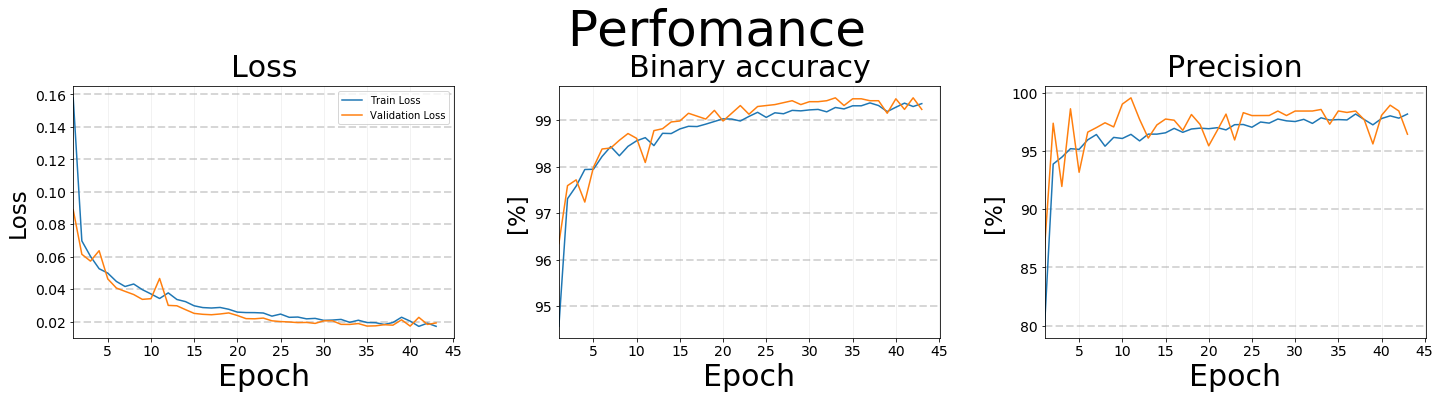

BEST EPOCH (early stopping): 33
--------------------
--> Loss: 0.0197
--> Binary accuracy: 0.9927
--> Precision: 0.9784
--> Precision a: 0.0
--> Precision b: 0.0
--> Precision c: 0.0
--> Precision d: 0.9784
--> F1 score: 0.1977
--> Val loss: 0.0184
--> Val binary accuracy: 0.9948
--> Val precision: 0.9856
--> Val precision a: 0.0
--> Val precision b: 0.0
--> Val precision c: 0.0
--> Val precision d: 0.9856
--> Val f1 score: 0.2001
--------------------------------------------------------------------------------------------------------------
-------------------------------------------------- INV2 --------------------------------------------------
-------------------------------------------------------------------------------------------------------------- 

TRAIN SET (80 %) --> INPUT (X): (4825, 24, 79) || OUTPUT (Y): (4825, 4) 
--> [('CLASS1', 0), ('CLASS2', 0), ('CLASS3', 1), ('CLASS4', 1375)]

VALID SET (20 %) --> INPUT (X):  (1207, 24, 79) || OUTPUT (Y):  (1207, 4)
--> [('CLASS1', 0)

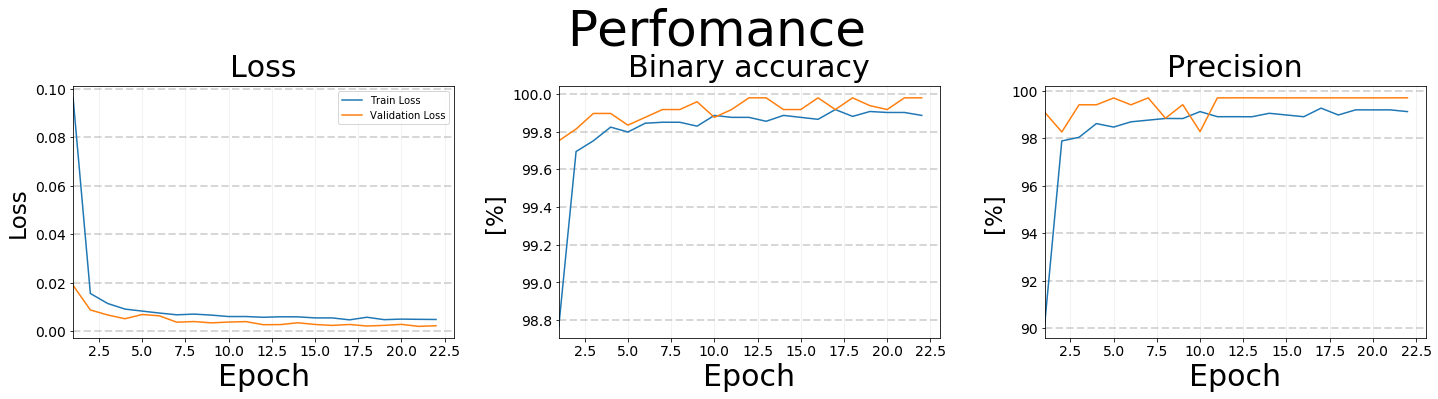

BEST EPOCH (early stopping): 12
--------------------
--> Loss: 0.0057
--> Binary accuracy: 0.9988
--> Precision: 0.9891
--> Precision a: 0.0
--> Precision b: 0.0
--> Precision c: 0.0
--> Precision d: 0.9891
--> F1 score: 0.111
--> Val loss: 0.0026
--> Val binary accuracy: 0.9998
--> Val precision: 0.9971
--> Val precision a: 0.0
--> Val precision b: 0.0
--> Val precision c: 0.0
--> Val precision d: 0.9971
--> Val f1 score: 0.1109
--------------------------------------------------------------------------------------------------------------
-------------------------------------------------- INV3 --------------------------------------------------
-------------------------------------------------------------------------------------------------------------- 

TRAIN SET (80 %) --> INPUT (X): (4953, 24, 79) || OUTPUT (Y): (4953, 4) 
--> [('CLASS1', 0), ('CLASS2', 0), ('CLASS3', 36), ('CLASS4', 2592)]

VALID SET (20 %) --> INPUT (X):  (1239, 24, 79) || OUTPUT (Y):  (1239, 4)
--> [('CLASS1', 0)

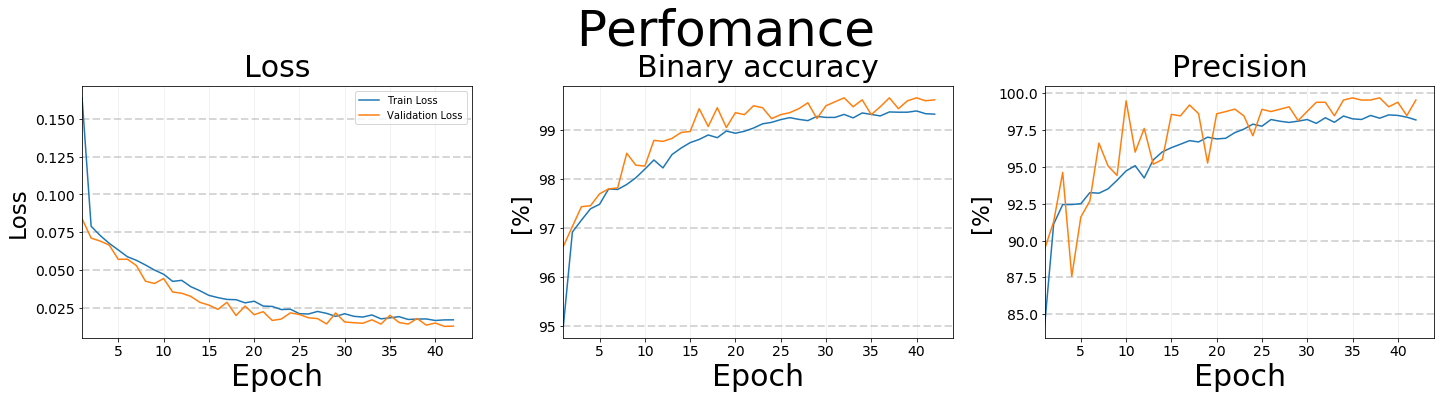

BEST EPOCH (early stopping): 32
--------------------
--> Loss: 0.0187
--> Binary accuracy: 0.9932
--> Precision: 0.9833
--> Precision a: 0.0
--> Precision b: 0.0
--> Precision c: 0.0
--> Precision d: 0.9833
--> F1 score: 0.2024
--> Val loss: 0.0146
--> Val binary accuracy: 0.9966
--> Val precision: 0.9938
--> Val precision a: 0.0
--> Val precision b: 0.0
--> Val precision c: 1.0
--> Val precision d: 0.9938
--> Val f1 score: 0.2022
--------------------------------------------------------------------------------------------------------------
-------------------------------------------------- INV4 --------------------------------------------------
-------------------------------------------------------------------------------------------------------------- 

TRAIN SET (80 %) --> INPUT (X): (4777, 24, 79) || OUTPUT (Y): (4777, 4) 
--> [('CLASS1', 0), ('CLASS2', 0), ('CLASS3', 0), ('CLASS4', 2592)]

VALID SET (20 %) --> INPUT (X):  (1195, 24, 79) || OUTPUT (Y):  (1195, 4)
--> [('CLASS1', 0)

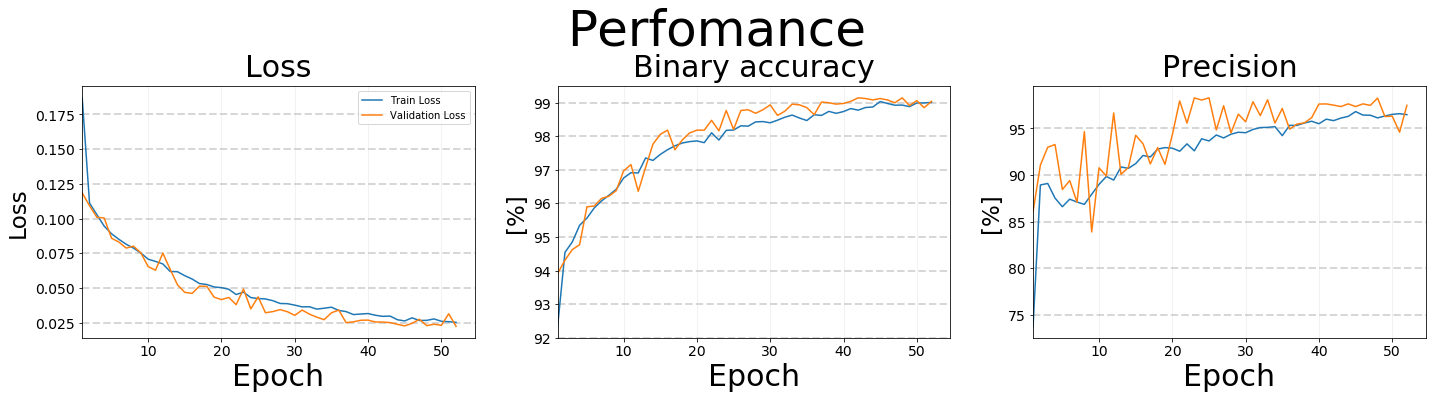

BEST EPOCH (early stopping): 42
--------------------
--> Loss: 0.0297
--> Binary accuracy: 0.9878
--> Precision: 0.9584
--> Precision a: 0.0
--> Precision b: 0.0
--> Precision c: 0.0
--> Precision d: 0.9584
--> F1 score: 0.1782
--> Val loss: 0.0255
--> Val binary accuracy: 0.9914
--> Val precision: 0.975
--> Val precision a: 0.0
--> Val precision b: 0.0
--> Val precision c: 0.0
--> Val precision d: 0.975
--> Val f1 score: 0.1799


In [86]:
if not grid_search and not pre_trained:
    for inv_name in inv_names:
        print("-" * 110 + "\n" + "-" * 50, inv_name, "-" * 50 + "\n" + "-" * 110, "\n")

        # Retrieve the dataset
        df = train_data[inv_name]
        
        # Get the parameters
        num_neurons = params[inv_name]['num_neurons']
        window_length = params[inv_name]['window_length']
        
        # Build the train/validation splits
        output_cols = [col for col in df.columns if class_prefix in col]
        feature_names, x_train, y_train, x_valid, y_valid = lstm_utils.prepare_splitted_training_data(df, output_cols, 
                                                                                                      window_length,
                                                                                                      enconding_one_obs, 
                                                                                                      verbose = False)
  
        idk_Isolation_class = [idk_class for idk_class, col in enumerate(output_cols) if 'isolamento' in col.lower()]
        
        # Initialize the LSTM
        num_input_features = x_train.shape[2]
        num_output_classes = y_train.shape[1]
        lstm_model = lstm_utils.initialize_lstm(num_neurons, window_length, num_input_features, num_output_classes, 
                                                classes_to_skip = idk_Isolation_class, enconding_one_obs = enconding_one_obs)

        # Train the LSTM 
        history, best_perfomances = lstm_utils.train_model(lstm_model, (x_train, y_train), (x_valid, y_valid), num_epochs, 
                                                           batch_size, shuffle_flag = True, visualize_graph = True)

        # Save the trained LSTM
        trained_inv_model[inv_name] = lstm_model
else:
    print("This step has been skipped.")

## Save the trained models

In [87]:
if not pre_trained:
    for inv_name in inv_names:
        print("-" * 110 + "\n" + "-" * 50, inv_name, "-" * 50 + "\n" + "-" * 110, "\n")
        
        trained_lstm = trained_inv_model[inv_name]

        # Save the best model
        file_name = f'{inv_name}_trained_model'
        
        if grid_search: 
            file_name += '_' + str(grid_search_best_params[inv_name]['Starting neurons']) + 'N' 
            file_name += '_' + str(grid_search_best_params[inv_name]['Window dimensions']) + "H"
        else: 
            file_name += '_' + str(params[inv_name]['num_neurons']) + 'N_' + str(params[inv_name]['window_length']) + "H"
            
        file_path = path.join(saving_path, subfolders[1], file_name)
        trained_lstm.save(file_path)
else:
    print("This step has been skipped.")

--------------------------------------------------------------------------------------------------------------
-------------------------------------------------- INV1 --------------------------------------------------
-------------------------------------------------------------------------------------------------------------- 



INFO:tensorflow:Assets written to: data/GALATINA/GALATINA/Imported data/1-hour averaged sampling/../../UC2 - LSTM/Trained models/INV1_trained_model_192N_24H/assets


INFO:tensorflow:Assets written to: data/GALATINA/GALATINA/Imported data/1-hour averaged sampling/../../UC2 - LSTM/Trained models/INV1_trained_model_192N_24H/assets


--------------------------------------------------------------------------------------------------------------
-------------------------------------------------- INV2 --------------------------------------------------
-------------------------------------------------------------------------------------------------------------- 



INFO:tensorflow:Assets written to: data/GALATINA/GALATINA/Imported data/1-hour averaged sampling/../../UC2 - LSTM/Trained models/INV2_trained_model_192N_24H/assets


INFO:tensorflow:Assets written to: data/GALATINA/GALATINA/Imported data/1-hour averaged sampling/../../UC2 - LSTM/Trained models/INV2_trained_model_192N_24H/assets


--------------------------------------------------------------------------------------------------------------
-------------------------------------------------- INV3 --------------------------------------------------
-------------------------------------------------------------------------------------------------------------- 



INFO:tensorflow:Assets written to: data/GALATINA/GALATINA/Imported data/1-hour averaged sampling/../../UC2 - LSTM/Trained models/INV3_trained_model_192N_24H/assets


INFO:tensorflow:Assets written to: data/GALATINA/GALATINA/Imported data/1-hour averaged sampling/../../UC2 - LSTM/Trained models/INV3_trained_model_192N_24H/assets


--------------------------------------------------------------------------------------------------------------
-------------------------------------------------- INV4 --------------------------------------------------
-------------------------------------------------------------------------------------------------------------- 



INFO:tensorflow:Assets written to: data/GALATINA/GALATINA/Imported data/1-hour averaged sampling/../../UC2 - LSTM/Trained models/INV4_trained_model_192N_24H/assets


INFO:tensorflow:Assets written to: data/GALATINA/GALATINA/Imported data/1-hour averaged sampling/../../UC2 - LSTM/Trained models/INV4_trained_model_192N_24H/assets


## Load the trained models

In [88]:
if system_name == SYSTEM_NAMES[2]:
    if avg_config:
        config_to_load = {inv_name : {'num_neurons': 192, 'window_length' : 36} for inv_name in inv_names}
    else:
        config_to_load = {
            'INV1': {
                'num_neurons': 192, 
                'window_length': 36
            },
            'INV2': {
                'num_neurons': 92, 
                'window_length':96
            },
            'INV4': {
                'num_neurons': 64, 
                'window_length': 6
            }
        }  
elif system_name == SYSTEM_NAMES[3]:
    if avg_config:
        config_to_load = {inv_name : {'num_neurons': 192, 'window_length' : 12} for inv_name in inv_names}
    else:
        config_to_load = {
            'INV1': {
                'num_neurons': 128, 
                'window_length': 120
            },
            'INV2': {
                'num_neurons': 64, 
                'window_length':48
            }
        }
    
elif system_name == SYSTEM_NAMES[4]:
    if avg_config:
        config_to_load = {inv_name : {'num_neurons': 192, 'window_length' : 12} for inv_name in inv_names}
    else:
        config_to_load = {
            'INV1': {
                'num_neurons': 128, 
                'window_length': 12
            },
            'INV2': {
                'num_neurons': 65, 
                'window_length':12
            },
            'INV3': {
                'num_neurons':33, 
                'window_length':12
            },
            'INV4': {
                'num_neurons':44, 
                'window_length':12
            }
    }
if pre_trained:
    display(config_to_load)

In [89]:
if pre_trained:
    for inv_name in inv_names:
        print("-" * 110 + "\n" + "-" * 50, inv_name, "-" * 50 + "\n" + "-" * 110, "\n")

        # Load the model
        file_name = f'{inv_name}_trained_model'
        file_name += "_" + str(config_to_load[inv_name]["num_neurons"]) + "N"
        file_name += "_" + str(config_to_load[inv_name]["window_length"]) + "H"
        file_path = path.join(saving_path, subfolders[1], file_name)
        loaded_inv_model = load_model(file_path)
        loaded_inv_model.summary()
        
        # Save the loaded model for each inverter
        trained_inv_model[inv_name] = loaded_inv_model
        
        print("\t\t\t\tThe trained LSTM model has been loaded.\n")
else:
    print("Loading models has been skipped")

Loading models has been skipped


## Predict the classes (i.e., allarms)

In [90]:
prob_threshold = 0.5

In [91]:
verbose = True

--------------------------------------------------------------------------------------------------------------
-------------------------------------------------- INV1 --------------------------------------------------
-------------------------------------------------------------------------------------------------------------- 

TEST DATA: 2592

			--------------------------------------------------------------------------------
				CLASS A: Allarme fusibile su polo negativo (HOURLY EVENTS: 0)
			--------------------------------------------------------------------------------


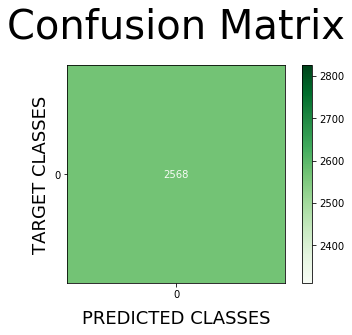


---------- CLASS METRICS ----------
ACCURACY:  100.0 %
PRECISION: 0.0 %
RECALL:    0.0 %
F1-SCORE:  0.0 %
MISCLASSIFICATION RATIO: 0.0 %

			--------------------------------------------------------------------------------
				CLASS B: Allarme fusibile su polo positivo (HOURLY EVENTS: 0)
			--------------------------------------------------------------------------------


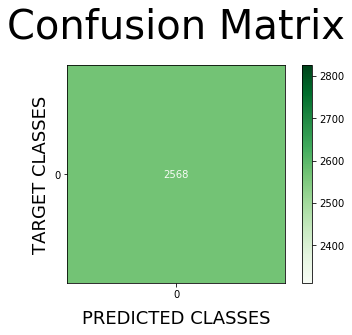


---------- CLASS METRICS ----------
ACCURACY:  100.0 %
PRECISION: 0.0 %
RECALL:    0.0 %
F1-SCORE:  0.0 %
MISCLASSIFICATION RATIO: 0.0 %

			--------------------------------------------------------------------------------
				CLASS C: Isolamento (HOURLY EVENTS: 0)
			--------------------------------------------------------------------------------


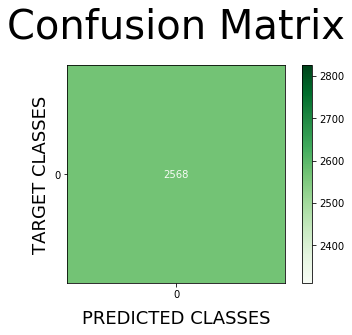


---------- CLASS METRICS ----------
ACCURACY:  100.0 %
PRECISION: 0.0 %
RECALL:    0.0 %
F1-SCORE:  0.0 %
MISCLASSIFICATION RATIO: 0.0 %

			--------------------------------------------------------------------------------
				CLASS D: String-box con corrente a 0 (HOURLY EVENTS: 1630)
			--------------------------------------------------------------------------------


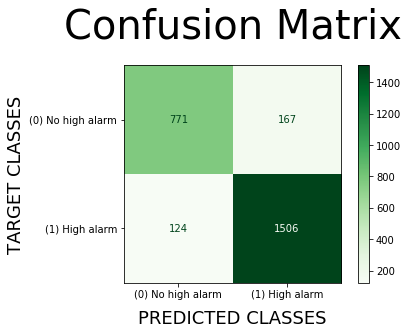

		     TN:  771 || FP: 167 
		     FN: 124 || TP:  1506


---------- CLASS METRICS ----------
ACCURACY:  88.67 %
PRECISION: 90.02 %
RECALL:    92.39 %
F1-SCORE:  91.19 %
MISCLASSIFICATION RATIO: 11.33 %

---------------------------------------- INV1: METRICS ----------------------------------------


,F1 score,Recall,Precision,Accuracy,Misclassification ratio,Hourly events
CLASS A: Allarme fusibile su polo negativo,0.00,0.00,0.00,100.00,0.00,0
CLASS B: Allarme fusibile su polo positivo,0.00,0.00,0.00,100.00,0.00,0
CLASS C: Isolamento,0.00,0.00,0.00,100.00,0.00,0
CLASS D: String-box con corrente a 0,91.19,92.39,90.02,88.67,11.33,1630


,F1 score,Recall,Precision,Accuracy,Hourly events
[AVG] ALL classes,22.8,23.1,22.5,97.17,1630


--------------------------------------------------------------------------------------------------------------
-------------------------------------------------- INV2 --------------------------------------------------
-------------------------------------------------------------------------------------------------------------- 

TEST DATA: 2596

			--------------------------------------------------------------------------------
				CLASS A: Allarme fusibile su polo negativo (HOURLY EVENTS: 0)
			--------------------------------------------------------------------------------


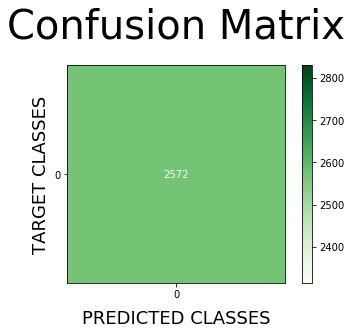


---------- CLASS METRICS ----------
ACCURACY:  100.0 %
PRECISION: 0.0 %
RECALL:    0.0 %
F1-SCORE:  0.0 %
MISCLASSIFICATION RATIO: 0.0 %

			--------------------------------------------------------------------------------
				CLASS B: Allarme fusibile su polo positivo (HOURLY EVENTS: 0)
			--------------------------------------------------------------------------------


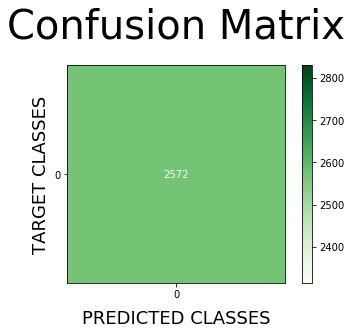


---------- CLASS METRICS ----------
ACCURACY:  100.0 %
PRECISION: 0.0 %
RECALL:    0.0 %
F1-SCORE:  0.0 %
MISCLASSIFICATION RATIO: 0.0 %

			--------------------------------------------------------------------------------
				CLASS C: Isolamento (HOURLY EVENTS: 1)
			--------------------------------------------------------------------------------


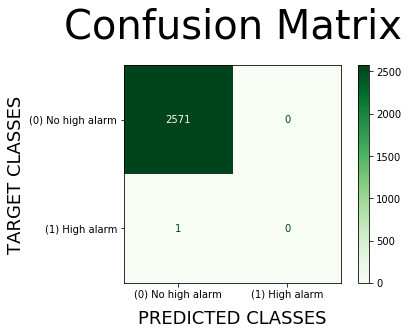

		     TN:  2571 || FP: 0 
		     FN: 1 || TP:  0


---------- CLASS METRICS ----------
ACCURACY:  99.96 %
PRECISION: 0.0 %
RECALL:    0.0 %
F1-SCORE:  0.0 %
MISCLASSIFICATION RATIO: 0.04 %

			--------------------------------------------------------------------------------
				CLASS D: String-box con corrente a 0 (HOURLY EVENTS: 737)
			--------------------------------------------------------------------------------


/home/vieri/anaconda3/envs/SAMPLE_tf/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


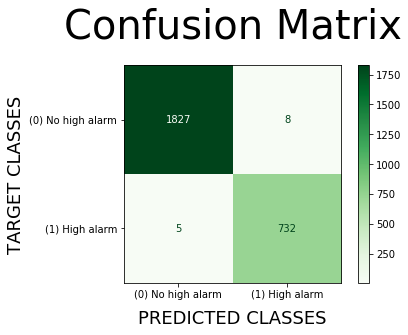

		     TN:  1827 || FP: 8 
		     FN: 5 || TP:  732


---------- CLASS METRICS ----------
ACCURACY:  99.49 %
PRECISION: 98.92 %
RECALL:    99.32 %
F1-SCORE:  99.12 %
MISCLASSIFICATION RATIO: 0.51 %

---------------------------------------- INV2: METRICS ----------------------------------------


,F1 score,Recall,Precision,Accuracy,Misclassification ratio,Hourly events
CLASS A: Allarme fusibile su polo negativo,0.00,0.00,0.00,100.00,0.00,0
CLASS B: Allarme fusibile su polo positivo,0.00,0.00,0.00,100.00,0.00,0
CLASS C: Isolamento,0.00,0.00,0.00,99.96,0.04,1
CLASS D: String-box con corrente a 0,99.12,99.32,98.92,99.49,0.51,737


,F1 score,Recall,Precision,Accuracy,Hourly events
[AVG] ALL classes,24.78,24.83,24.73,99.86,738


--------------------------------------------------------------------------------------------------------------
-------------------------------------------------- INV3 --------------------------------------------------
-------------------------------------------------------------------------------------------------------------- 

TEST DATA: 2665

			--------------------------------------------------------------------------------
				CLASS A: Allarme fusibile su polo negativo (HOURLY EVENTS: 0)
			--------------------------------------------------------------------------------


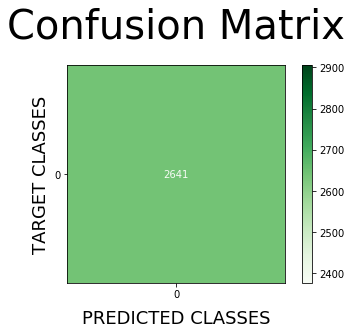


---------- CLASS METRICS ----------
ACCURACY:  100.0 %
PRECISION: 0.0 %
RECALL:    0.0 %
F1-SCORE:  0.0 %
MISCLASSIFICATION RATIO: 0.0 %

			--------------------------------------------------------------------------------
				CLASS B: Allarme fusibile su polo positivo (HOURLY EVENTS: 0)
			--------------------------------------------------------------------------------


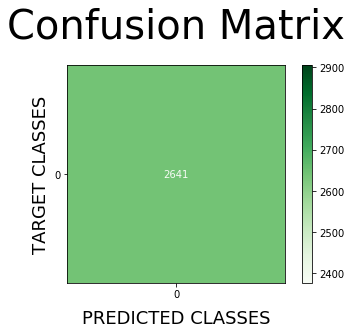


---------- CLASS METRICS ----------
ACCURACY:  100.0 %
PRECISION: 0.0 %
RECALL:    0.0 %
F1-SCORE:  0.0 %
MISCLASSIFICATION RATIO: 0.0 %

			--------------------------------------------------------------------------------
				CLASS C: Isolamento (HOURLY EVENTS: 20)
			--------------------------------------------------------------------------------


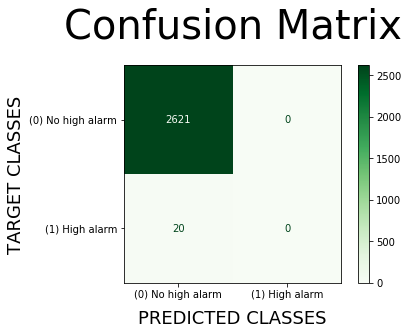

		     TN:  2621 || FP: 0 
		     FN: 20 || TP:  0


---------- CLASS METRICS ----------
ACCURACY:  99.24 %
PRECISION: 0.0 %
RECALL:    0.0 %
F1-SCORE:  0.0 %
MISCLASSIFICATION RATIO: 0.76 %

			--------------------------------------------------------------------------------
				CLASS D: String-box con corrente a 0 (HOURLY EVENTS: 1390)
			--------------------------------------------------------------------------------


/home/vieri/anaconda3/envs/SAMPLE_tf/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


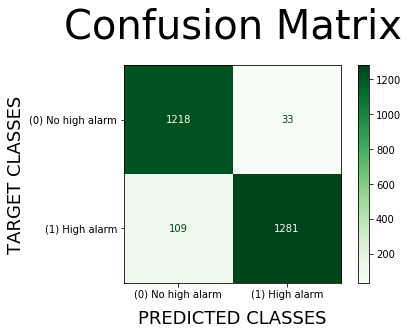

		     TN:  1218 || FP: 33 
		     FN: 109 || TP:  1281


---------- CLASS METRICS ----------
ACCURACY:  94.62 %
PRECISION: 97.49 %
RECALL:    92.16 %
F1-SCORE:  94.75 %
MISCLASSIFICATION RATIO: 5.38 %

---------------------------------------- INV3: METRICS ----------------------------------------


,F1 score,Recall,Precision,Accuracy,Misclassification ratio,Hourly events
CLASS A: Allarme fusibile su polo negativo,0.00,0.00,0.00,100.00,0.00,0
CLASS B: Allarme fusibile su polo positivo,0.00,0.00,0.00,100.00,0.00,0
CLASS C: Isolamento,0.00,0.00,0.00,99.24,0.76,20
CLASS D: String-box con corrente a 0,94.75,92.16,97.49,94.62,5.38,1390


,F1 score,Recall,Precision,Accuracy,Hourly events
[AVG] ALL classes,23.69,23.04,24.37,98.46,1410


--------------------------------------------------------------------------------------------------------------
-------------------------------------------------- INV4 --------------------------------------------------
-------------------------------------------------------------------------------------------------------------- 

TEST DATA: 2571

			--------------------------------------------------------------------------------
				CLASS A: Allarme fusibile su polo negativo (HOURLY EVENTS: 0)
			--------------------------------------------------------------------------------


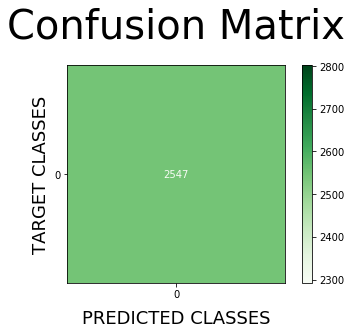


---------- CLASS METRICS ----------
ACCURACY:  100.0 %
PRECISION: 0.0 %
RECALL:    0.0 %
F1-SCORE:  0.0 %
MISCLASSIFICATION RATIO: 0.0 %

			--------------------------------------------------------------------------------
				CLASS B: Allarme fusibile su polo positivo (HOURLY EVENTS: 0)
			--------------------------------------------------------------------------------


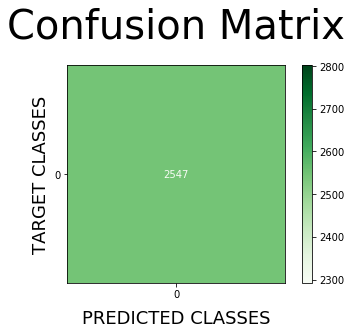


---------- CLASS METRICS ----------
ACCURACY:  100.0 %
PRECISION: 0.0 %
RECALL:    0.0 %
F1-SCORE:  0.0 %
MISCLASSIFICATION RATIO: 0.0 %

			--------------------------------------------------------------------------------
				CLASS C: Isolamento (HOURLY EVENTS: 0)
			--------------------------------------------------------------------------------


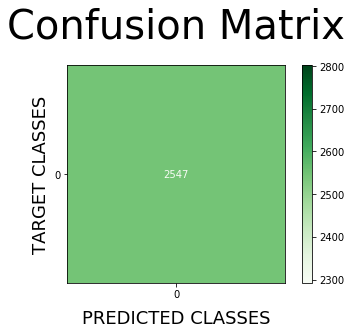


---------- CLASS METRICS ----------
ACCURACY:  100.0 %
PRECISION: 0.0 %
RECALL:    0.0 %
F1-SCORE:  0.0 %
MISCLASSIFICATION RATIO: 0.0 %

			--------------------------------------------------------------------------------
				CLASS D: String-box con corrente a 0 (HOURLY EVENTS: 1390)
			--------------------------------------------------------------------------------


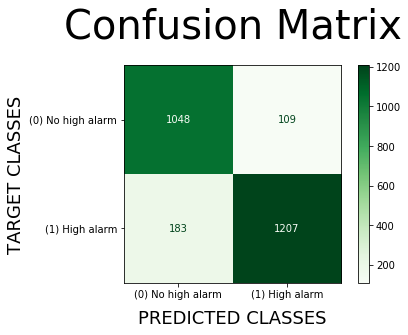

		     TN:  1048 || FP: 109 
		     FN: 183 || TP:  1207


---------- CLASS METRICS ----------
ACCURACY:  88.54 %
PRECISION: 91.72 %
RECALL:    86.83 %
F1-SCORE:  89.21 %
MISCLASSIFICATION RATIO: 11.46 %

---------------------------------------- INV4: METRICS ----------------------------------------


,F1 score,Recall,Precision,Accuracy,Misclassification ratio,Hourly events
CLASS A: Allarme fusibile su polo negativo,0.00,0.00,0.00,100.00,0.00,0
CLASS B: Allarme fusibile su polo positivo,0.00,0.00,0.00,100.00,0.00,0
CLASS C: Isolamento,0.00,0.00,0.00,100.00,0.00,0
CLASS D: String-box con corrente a 0,89.21,86.83,91.72,88.54,11.46,1390


,F1 score,Recall,Precision,Accuracy,Hourly events
[AVG] ALL classes,22.3,21.71,22.93,97.14,1390


In [92]:
inv_metrics = dict()
for inv_name in inv_names:
    print("-" * 110 + "\n" + "-" * 50, inv_name, "-" * 50 + "\n" + "-" * 110, "\n")
    
    # Retrieve the dataset
    df = test_data[inv_name]
    
    # Retrieve the trained model
    model = trained_inv_model[inv_name]
    
    if grid_search:
        window_length = inv_best_scores[inv_name]['Window dimensions']
    if pre_trained:
        window_length = config_to_load[inv_name]['window_length']
    else:
        window_length = params[inv_name]['window_length']
    
    # Prepare the input data 
    feature_names, x_values, y_classes = lstm_utils.generate_data_sequences(df, output_cols, window_length, enconding_one_obs)
    
    # Get the output of the model
    predictions = model.predict(x_values, batch_size, verbose = 0)
    
    # Turn the probabilities into binary classes
    predicted_classes = np.where(predictions <= prob_threshold, 0, 1)
    
    assert predicted_classes.shape == y_classes.shape, f'DIMENSIONAL ERROR: TEST DATA: {y_classes.shape} '\
                                                       f'!= PREDICTED DATA: {predicted_classes.shape}'
    # Compute the metrics for each class
    print(f"TEST DATA: {len(df)}")
    class_metrics = lstm_utils.evaluate_predictions(predicted_classes, y_classes, output_cols, verbose)
           
    # Save the metrics
    metrics_df = pd.DataFrame.from_dict(class_metrics, orient = 'index')
    metrics_df.iloc[:, :-1] = (metrics_df.iloc[:, :-1] * 100).round(decimals = 2)
    print("\n" + "-" * 40, inv_name + ": METRICS", "-" * 40)
    display(metrics_df)
    
    # Add a row for the avg scores
    avg_df = metrics_df.iloc[:, :-2].mean().to_frame().transpose().round(decimals = 2)
    avg_df['Hourly events'] = metrics_df['Hourly events'].sum()
    avg_df.index = ['[AVG] ALL classes']
    display(avg_df)
    
    # Visualize and save the metrics
    inv_metrics[inv_name] = metrics_df

## Overview

In [93]:
file_name = 'Metrics' + ('_AVG_configs' if avg_config else '')
file_path = path.join(saving_path, subfolders[2], file_name + '.xlsx')

writer = pd.ExcelWriter(file_path)

In [94]:
print("-" * 110 + "\n" + "-" * 50, "OVERVIEW: Alarms", "-" * 50 + "\n" + "-" * 110, "\n")
list_metrics = []
for inv_name, metrics in inv_metrics.items():
    if not isinstance(metrics.index, pd.MultiIndex):
        metrics.index = pd.MultiIndex.from_tuples(tuple(zip([inv_name for j in range(len(df))], metrics.index)))
    list_metrics.append(metrics)
alarm_overall_metrics = pd.concat(list_metrics)
display(alarm_overall_metrics)

# Save as excel
alarm_overall_metrics.to_excel(writer, sheet_name = "By inverters")

--------------------------------------------------------------------------------------------------------------
-------------------------------------------------- OVERVIEW: Alarms --------------------------------------------------
-------------------------------------------------------------------------------------------------------------- 



F1 score  Recall  Precision  \
INV1 CLASS A: Allarme fusibile su polo negativo      0.00    0.00       0.00   
     CLASS B: Allarme fusibile su polo positivo      0.00    0.00       0.00   
     CLASS C: Isolamento                             0.00    0.00       0.00   
     CLASS D: String-box con corrente a 0           91.19   92.39      90.02   
INV2 CLASS A: Allarme fusibile su polo negativo      0.00    0.00       0.00   
     CLASS B: Allarme fusibile su polo positivo      0.00    0.00       0.00   
     CLASS C: Isolamento                             0.00    0.00       0.00   
     CLASS D: String-box con corrente a 0           99.12   99.32      98.92   
INV3 CLASS A: Allarme fusibile su polo negativo      0.00    0.00       0.00   
     CLASS B: Allarme fusibile su polo positivo      0.00    0.00       0.00   
     CLASS C: Isolamento                             0.00    0.00       0.00   
     CLASS D: String-box con corrente a 0           94.75   92.16      97.49   
INV4 CLASS A: Allarme fusibile su polo negativo      0.00    0.00       0.00   
     CLASS B: Allarme fusibile su polo positivo      0.00    0.00       0.00   
     CLASS C: Isolamento                             0.00    0.00       0.00   
     CLASS D: String-box con corrente a 0           89.21   86.83      91.72   

                                                 Accuracy  \
INV1 CLASS A: Allarme fusibile su polo negativo    100.00   
     CLASS B: Allarme fusibile su polo positivo    100.00   
     CLASS C: Isolamento                           100.00   
     CLASS D: String-box con corrente a 0           88.67   
INV2 CLASS A: Allarme fusibile su polo negativo    100.00   
     CLASS B: Allarme fusibile su polo positivo    100.00   
     CLASS C: Isolamento                            99.96   
     CLASS D: String-box con corrente a 0           99.49   
INV3 CLASS A: Allarme fusibile su polo negativo    100.00   
     CLASS B: Allarme fusibile su polo positivo    100.00   
     CLASS C: Isolamento                            99.24   
     CLASS D: String-box con corrente a 0           94.62   
INV4 CLASS A: Allarme fusibile su polo negativo    100.00   
     CLASS B: Allarme fusibile su polo positivo    100.00   
     CLASS C: Isolamento                           100.00   
     CLASS D: String-box con corrente a 0           88.54   

                                                 Misclassification ratio  \
INV1 CLASS A: Allarme fusibile su polo negativo                     0.00   
     CLASS B: Allarme fusibile su polo positivo                     0.00   
     CLASS C: Isolamento                                            0.00   
     CLASS D: String-box con corrente a 0                          11.33   
INV2 CLASS A: Allarme fusibile su polo negativo                     0.00   
     CLASS B: Allarme fusibile su polo positivo                     0.00   
     CLASS C: Isolamento                                            0.04   
     CLASS D: String-box con corrente a 0                           0.51   
INV3 CLASS A: Allarme fusibile su polo negativo                     0.00   
     CLASS B: Allarme fusibile su polo positivo                     0.00   
     CLASS C: Isolamento                                            0.76   
     CLASS D: String-box con corrente a 0                           5.38   
INV4 CLASS A: Allarme fusibile su polo negativo                     0.00   
     CLASS B: Allarme fusibile su polo positivo                     0.00   
     CLASS C: Isolamento                                            0.00   
     CLASS D: String-box con corrente a 0                          11.46   

                                                 Hourly events  
INV1 CLASS A: Allarme fusibile su polo negativo              0  
     CLASS B: Allarme fusibile su polo positivo              0  
     CLASS C: Isolamento                                     0  
     CLASS D: String-box con corrente a 0                 1630  
INV2 CLASS A: Allarme fusibile s

In [95]:
# A.2) Grouped metrics
alarm_overall_metrics = alarm_overall_metrics.droplevel(level = 0)
alarm_overall_metrics = alarm_overall_metrics.groupby(by = alarm_overall_metrics.index)
grouped_alarm_overall_metrics = alarm_overall_metrics.mean()
grouped_alarm_overall_metrics['Hourly events'] = alarm_overall_metrics.sum()['Hourly events']
grouped_alarm_overall_metrics = grouped_alarm_overall_metrics.round(decimals = 2)
display(grouped_alarm_overall_metrics)

# Save as excel
grouped_alarm_overall_metrics.to_excel(writer, sheet_name = "By alarms")

if pre_trained:
    model_configs = pd.DataFrame().from_dict(config_to_load, orient = 'index')
else:
    model_configs = pd.DataFrame().from_dict(params, orient = 'index')
model_configs.to_excel(writer, sheet_name = "Configs")

writer.save()

,F1 score,Recall,Precision,Accuracy,Misclassification ratio,Hourly events
CLASS A: Allarme fusibile su polo negativo,0.00,0.00,0.00,100.00,0.00,0
CLASS B: Allarme fusibile su polo positivo,0.00,0.00,0.00,100.00,0.00,0
CLASS C: Isolamento,0.00,0.00,0.00,99.80,0.20,21
CLASS D: String-box con corrente a 0,93.57,92.68,94.54,92.83,7.17,5147


In [96]:
print("-" * 110 + "\n" + "-" * 50, "OVERVIEW: Inverters", "-" * 50 + "\n" + "-" * 110, "\n")
inv_overall_metrics = pd.DataFrame.from_dict({"[AVG] " + inv_name: metrics.iloc[:, :-1].mean()
                                              for inv_name, metrics in inv_metrics.items()},
                                             orient = 'index').round(decimals = 2)
display(inv_overall_metrics)
display(inv_overall_metrics.mean().to_frame().round(2).transpose().rename(index = {0: '[AVG] INVs'}))

--------------------------------------------------------------------------------------------------------------
-------------------------------------------------- OVERVIEW: Inverters --------------------------------------------------
-------------------------------------------------------------------------------------------------------------- 



,F1 score,Recall,Precision,Accuracy,Misclassification ratio
[AVG] INV1,22.80,23.10,22.50,97.17,2.83
[AVG] INV2,24.78,24.83,24.73,99.86,0.14
[AVG] INV3,23.69,23.04,24.37,98.46,1.54
[AVG] INV4,22.30,21.71,22.93,97.14,2.86


,F1 score,Recall,Precision,Accuracy,Misclassification ratio
[AVG] INVs,23.39,23.17,23.63,98.16,1.84
